In [4]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import string
import numpy as np
import difflib
import os


import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix,roc_curve,f1_score,precision_score,recall_score,auc

#NLTK
import nltk

from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw')


from sklearn.naive_bayes import MultinomialNB

import enchant  # pip install pyenchant et sudo apt install aspell-fr (RESTART KERNEL)
from enchant.checker import SpellChecker
fr_dict = enchant.Dict("fr_FR")
import spacy
spacy_fr = spacy.load('fr_core_news_sm',disable=['tagger', 'parser', 'ner'])

import torch
from transformers.modeling_camembert import CamembertForSequenceClassification
from transformers.tokenization_camembert import CamembertTokenizer

from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import CamembertForSequenceClassification, AdamW, CamembertConfig
from transformers import get_linear_schedule_with_warmup


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/tdenimal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/tdenimal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw to /home/tdenimal/nltk_data...
[nltk_data]   Package omw is already up-to-date!


In [2]:
def segment_str(chars,fr_dict, exclude=None):
    """
    Segment a string of chars using the pyenchant vocabulary.
    Keeps longest possible words that account for all characters,
    and returns list of segmented words.

    :param chars: (str) The character string to segment.
    :param exclude: (set) A set of string to exclude from consideration.
                    (These have been found previously to lead to dead ends.)
                    If an excluded word occurs later in the string, this
                    function will fail.
    """
    words = []

    if not chars.isalpha():  # don't check punctuation etc.; needs more work
        return [chars]

    if not exclude:
        exclude = set()

    working_chars = chars
    while working_chars:
        # iterate through segments of the chars starting with the longest segment possible
        for i in range(len(working_chars), 1, -1):
            segment = working_chars[:i]
            if fr_dict.check(segment) and segment not in exclude:
                words.append(segment)
                working_chars = working_chars[i:]
                break
        else:  # no matching segments were found
            if words:
                exclude.add(words[-1])
                return segment_str(chars,fr_dict, exclude=exclude)
            # let the user know a word was missing from the dictionary,
            # but keep the word
            print('"{chars}" not in dictionary (so just keeping as one segment)!'
                  .format(chars=chars))
            return [chars]
    # return a list of words based on the segmentation
    return words

In [3]:
def spell_corrector(text,fr_dict):
    
    words = text.split()
    
    for i,w in enumerate(words):
        
        #check word syntax
        if not fr_dict.check(w):
            best_words = []
            best_ratio = 0
            suggests = set(fr_dict.suggest(w))
            for w_candidate in suggests:
                curr_ratio = difflib.SequenceMatcher(None, w, w_candidate).ratio()
                if curr_ratio > best_ratio:
                    best_words = set([w_candidate])
                    #best_words = [w_candidate]
                    best_ratio = curr_ratio
                elif curr_ratio == best_ratio:
                    best_words.add(w_candidate)
                    
            #replace word with best_words
            words.pop(i)
            #best_words.reverse()
            for bw in best_words:
                words.insert(i,bw)
    return " ".join([x for x in words])

In [4]:
#Remove companies names from review
def remove_specific(text):
    new_text = [w for w in text if w not in companies_list]
    return new_text

def lemmatize(text,spacy_fr):
    #Stemmatize words + delete stop_words
    doc = spacy_fr(text)
    new_text = [token.lemma_ for token in doc if token.text not in stopwords.words('french')]
    return new_text

In [5]:
def truncate_n_padding(sequences, max_len,padding_value=0):
    tr_n_pad_array = []
    for seq in sequences:
        tr_n_pad_array += [seq[:max_len] + [padding_value]*(max_len-len(seq))]
    return np.stack( tr_n_pad_array, axis=0 )

In [7]:
def load_jsons_df(data_dir = "/home/tdenimal/dev/hackatech_ovh/scrap_data/", language="fr"):
    data = []

    for filename in os.listdir(data_dir):
        if filename.endswith(".json"): 
             # print(os.path.join(directory, filename))
            with open(data_dir+filename, "r") as infile:
                data += json.loads(infile.read())
        else:
            continue
            
    
    result_df = pd.DataFrame(data)
    
    return result_df[result_df["language"] == language]
    

In [8]:
df_reviews = load_jsons_df(data_dir = "/home/tdenimal/dev/hackatech_ovh/scrap_data/", language="fr")
df_reviews.head(10)

,company,review_id,date,language,title,content,overall_rating,reliability_rating,pricing_rating,user_friendly_rating,support_rating,features_rating
99,a-a-hebergement,112761,24/01/2020,fr,"Extrêmement bien, rien à redire","Ayant acheté 1 an dans ce service, j'en suis e...",10.0,10.0,10.0,10.0,10.0,10.0
100,a-a-hebergement,112067,14/01/2020,fr,Quand un novice gère son site comme un expert,"Je débute en webmarketing, je suis au stade ''...",10.0,10.0,10.0,10.0,10.0,10.0
101,a-a-hebergement,111886,11/01/2020,fr,Hébergement web très bien,Je débute avec cette hébergement mais je le tr...,8.4,10.0,8.0,8.0,8.0,8.0
102,a-a-hebergement,111359,03/01/2020,fr,Avis sur A-a-Hébergement,"Très très bon hébergeur, franchement j'étais s...",7.6,8.0,6.0,8.0,8.0,8.0
103,a-a-hebergement,111112,28/12/2019,fr,les tarifs et le mailing list,"dernièrement les tarifs ont presque doublés , ...",8.8,10.0,4.0,10.0,10.0,10.0
104,a-a-hebergement,110323,14/12/2019,fr,Avis sur A-A hébergement,"Très très bon hébergeur, franchement j'étais s...",8.4,10.0,6.0,10.0,10.0,6.0
105,a-a-hebergement,110153,11/12/2019,fr,Très bien c'était ce que je cherche exactement,Je lance une nouvelle activité donc je n'avais...,10.0,10.0,10.0,10.0,10.0,10.0
106,a-a-hebergement,108327,13/11/2019,fr,excellent service,impeccable service et offres,9.2,10.0,8.0,10.0,10.0,8.0
107,a-a-hebergement,107895,07/11/2019,fr,rien a dire parfait,rien a dire parfait +++++,10.0,10.0,10.0,10.0,10.0,10.0
108,a-a-hebergement,107513,02/11/2019,fr,Excellent hosting,Service hébergement impeccable que j'utilise d...,10.0,10.0,10.0,10.0,10.0,10.0


In [9]:
df_reviews = df_reviews[["company","title","content","overall_rating"]]

In [10]:
#Fill na
df_reviews["title"] = df_reviews["title"].fillna("")
df_reviews["content"] = df_reviews["content"].fillna("")

In [11]:
df_reviews["full_content"] = df_reviews["title"] + " " +  df_reviews["content"]
df_reviews["company"] = df_reviews["company"].apply(lambda x : x.lower())
df_reviews["company2"] = df_reviews["company"].apply(lambda x : x.replace("-"," "))
df_reviews["company3"] = df_reviews["company"].apply(lambda x : x.replace("e","é"))
df_reviews["full_content"] = df_reviews["full_content"].apply(lambda x : x.lower())

In [12]:
#Replace company with fournisseur
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(x['company'],'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(x['company2'],'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(x['company3'],'un hébergeur'), axis=1)

df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(x['company'],'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(x['company2'],'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(x['company3'],'un hébergeur'), axis=1)

#Specific replace for training
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("agsahosting",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("agsa",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("1and1",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("hospapa",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("hostpapa",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("hostgator",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("hoster",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("hosting",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("infomaniak",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("kimsufi",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("klaba",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("lws",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("nuxit",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("o2switch",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("o2",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("o2s",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("02switch",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("ovh",'un hébergeur'), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace("wistee",'un hébergeur'), axis=1)




#Remplacer acronymes
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(" bcp ",' beaucoup '), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(" asso ",' association '), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(" assitance ",' assistance '), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(" qqn "," quelqu'un "), axis=1)
df_reviews["full_content"] = df_reviews.apply(lambda x : x['full_content'].replace(" qq ",' quelque '), axis=1)

In [13]:
df_reviews["company"].sort_values().unique()

array(['000webhost', '007hebergementcomfr', '1&1 ionos', '11', '1et1',
       '1hebergementfr', '2freehosting', '3waccess', '4-community',
       '4communitynet', 'a-a-hebergement', 'a2-hosting', 'abergement',
       'adifco', 'agsahostingfr', 'alls-heberg', 'allsite',
       'alpes-hosting', 'alwaysdata', 'amen', 'amen-fr', 'anotherlight',
       'aqua ray', 'aquaray', 'archicool', 'archivehostfr', 'arsys',
       'arvixe', 'arzhost', 'aspserveur', 'associationappuifr',
       'associationredhebergfr', 'associationweb4all',
       'associationxcluradiofr', 'astral-internet', 'atspace-com',
       'awardspace', 'b-powers', 'behostings', 'besthost',
       'blazing-fast-host', 'blazingfast', 'bmis', 'boxis', 'boxisfr',
       'byethost', 'cdn77', 'chemicloud', 'cineteck', 'claranetfr',
       'clicasso', 'cliranet', 'cloud-vip', 'club-hosting', 'codenet',
       'contabo', 'crayminternettechnologyfr', 'creaty-totality-web',
       'creaweb06fr', 'cubyhebergsfr', 'customeventhostingfr', 

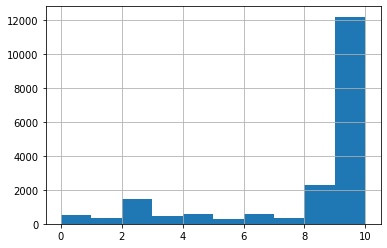

In [14]:
df_reviews["overall_rating"].hist()

In [15]:
### Define binary class - threshold is 5
df_reviews["sentiment"] = df_reviews["overall_rating"].apply(lambda x: 1 if x > 5 else 0)

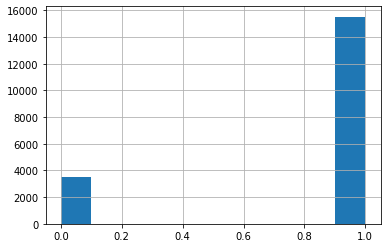

In [16]:
df_reviews["sentiment"].hist()

In [12]:
#Split train/test

X_train, X_test, y_train, y_test = train_test_split(df_reviews["full_content"], \
                                                    df_reviews['sentiment'], \
                                                    test_size=0.2, random_state=42)

In [18]:
tfidf = TfidfVectorizer(lowercase=True,
                        ngram_range=(1,1),
                        max_features=5000,
                        stop_words=stopwords.words("french")
                       )

In [19]:
tf_train = tfidf.fit_transform(X_train)
tf_test = tfidf.transform(X_test)

In [20]:
#Weight more samples from minor class
clf = MultinomialNB(alpha=0.4, class_prior=None, fit_prior=False)
clf.fit(tf_train, y_train,sample_weight=4.5*(np.squeeze(np.array([y_train == 0]))) + np.squeeze(np.array([y_train == 1]))
       )



MultinomialNB(alpha=0.4, class_prior=None, fit_prior=False)

In [21]:
#Dataset de train bien equilibre
clf.class_count_

array([12631.5, 12421. ])

In [22]:
preds = clf.predict(tf_test)
f1_score(y_test,preds)

0.9503095198259998

In [23]:
fpr, tpr, thresholds = roc_curve(y_test, preds, pos_label=1)
auc(fpr, tpr)

0.9350998802061261

Confusion matrix, without normalization
[[ 671   31]
 [ 266 2840]]
Normalized confusion matrix
[[0.95584046 0.04415954]
 [0.0856407  0.9143593 ]]


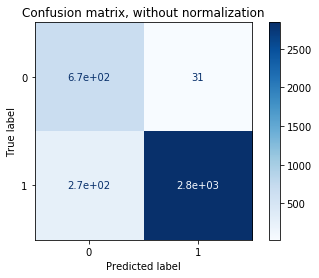

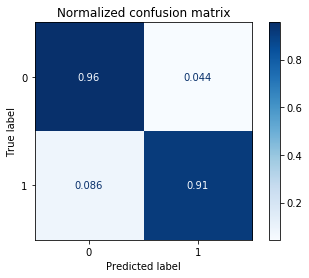

In [24]:
# Plot non-normalized confusion matrix
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(clf, tf_test, y_test.to_numpy(),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [25]:
neg_class_prob_sorted = clf.feature_log_prob_[0, :].argsort()
pos_class_prob_sorted = clf.feature_log_prob_[1, :].argsort()

print(np.take(tfidf.get_feature_names(), neg_class_prob_sorted[:30]))
print(np.take(tfidf.get_feature_names(), pos_class_prob_sorted[:30]))

['œuvre' 'rapidite' 'apprentissage' 'facilite' 'faciliter' 'supers'
 'clairs' 'apprecie' 'incontournable' 'apportant' 'accompagne' 'ravie'
 'reactivité' 'fabuleux' 'suivait' 'conquis' 'clermont' 'suivaient'
 'recherché' 'impressionné' 'impeccables' 'impecable' 'suffisantes'
 'studio' 'stress' 'ferrand' 'recommandes' 'fantastique' 'recommandons'
 'extra']
['déconseillé' 'infoscore' 'minables' 'modem' 'expiré' 'eurosht'
 'royalement' 'terminée' 'prélevés' 'supprimés' 'créance' 'escroquerie'
 'epp' 'récuperer' 'encaissement' 'deconseille' 'dette' 'avocats' 'avocat'
 'dgccrf' 'dégradée' 'autorisation' 'déconnecté' 'tournure' 'judiciaire'
 'traitance' 'tribunal' 'banni' 'consentement' 'innaccessible']


In [26]:
from lime import lime_text
from lime.lime_text import LimeTextExplainer
from sklearn.pipeline import make_pipeline
c = make_pipeline(tfidf, clf)
explainer = LimeTextExplainer(class_names=['NEGATIF','POSITIF'],bow=False)

idx = 28


input_seq=X_test.iloc[idx]

exp = explainer.explain_instance(input_seq,
                                 c.predict_proba,
                                 num_samples=20000,
                                 num_features=10)
print('Document id: %d' % idx)
print('Probability(1) =', c.predict_proba([input_seq])[0,1])
print('True class: %s' % y_test.iloc[idx])

exp.show_in_notebook()

Document id: 28
Probability(1) = 0.9854824621524619
True class: 1


In [ ]:
# TEST FLAIR
# SAVE CORPUS

In [41]:
#Split train/test/validation

#df_reviews['label'] = '__label__' + df_reviews['sentiment'].apply(lambda x : "neg" if x == 0 else "pos").astype(str)

df_reviews['label'] = df_reviews['sentiment'].apply(lambda x : "neg" if x == 0 else "pos").astype(str)


X_trainval, X_test, y_trainval, y_test = train_test_split(df_reviews["full_content"], \
                                                    df_reviews['label'], \
                                                    test_size=0.2, random_state=42)


X_train, X_val, y_train, y_val = train_test_split(X_trainval, \
                                                    y_trainval, \
                                                    test_size=0.1, random_state=42)

In [76]:
train_df = pd.DataFrame({ 'label': y_train, 'text': X_train })
val_df = pd.DataFrame({ 'label': y_val, 'text': X_val })
test_df = pd.DataFrame({ 'label': y_test, 'text': X_test })


train_df.to_csv('train.tsv', 
                sep='|', 
                index = False, 
                header = False,
               encoding="utf-8")

val_df.to_csv('val.tsv', 
              sep='|', 
              index = False, 
              header = False,
             encoding="utf-8")

test_df.to_csv('test.tsv', 
               sep='|', 
               index = False, 
               header = False,
              encoding="utf-8")

In [2]:
from flair.datasets import ColumnCorpus,ClassificationCorpus,CSVClassificationCorpus
from flair.data import Corpus


# define columns
columns = {0: 'label', 1: 'text'}

# this is the folder in which train, test and dev files reside
data_folder = './'

# init a corpus using column format, data folder and the names of the train, dev and test files
corpus: Corpus = CSVClassificationCorpus(data_folder, 
                              columns,
                              train_file='train.tsv',
                              test_file='test.tsv',
                              dev_file='val.tsv',
                              delimiter='|'
                              )

2020-03-05 21:48:03,523 Reading data from .
2020-03-05 21:48:03,525 Train: train.tsv
2020-03-05 21:48:03,526 Dev: val.tsv
2020-03-05 21:48:03,528 Test: test.tsv


In [3]:
label_dict = corpus.make_label_dictionary()

2020-03-05 21:48:06,956 Computing label dictionary. Progress:


100%|██████████| 13705/13705 [00:08<00:00, 1575.84it/s]

2020-03-05 21:48:16,222 [b'pos', b'neg']


In [87]:
for i,c in enumerate(corpus._train):
    if len(c.tokens) == 0:
        print(i)

803
2020
4850
5551
7542
11701


In [88]:
type(corpus._train)

flair.datasets.CSVClassificationDataset

In [90]:
corpus._train[11700]

Sentence: "j'ai contacté à plusieurs reprises le service client d'un hébergeur , tils ont toujours su répondre très rapidement et solutionner mes demandes . un service client avec une réactivité sans faille et des opérateurs toujours très agréables et à l'écoute ! nous étions chez un autre hébergeur avant et nous voyons vraiment la différence . enfin un hébergeur disponible et efficace ! a recommander ." - 65 Tokens

In [92]:
train_df.iloc[11701]

label    pos
text        
Name: 13356, dtype: object

In [79]:
stats = corpus.obtain_statistics()
print(stats)

{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 13705,
        "number_of_documents_per_class": {
            "pos": 11205,
            "neg": 2500
        },
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 918855,
            "min": 0,
            "max": 1816,
            "avg": 67.0452389638818
        }
    },
    "TEST": {
        "dataset": "TEST",
        "total_number_of_documents": 3808,
        "number_of_documents_per_class": {
            "pos": 3106,
            "neg": 702
        },
        "number_of_tokens_per_tag": {},
        "number_of_tokens": {
            "total": 261758,
            "min": 0,
            "max": 758,
            "avg": 68.73897058823529
        }
    },
    "DEV": {
        "dataset": "DEV",
        "total_number_of_documents": 1523,
        "number_of_documents_per_class": {
            "pos": 1216,
            "neg": 307
        },
        "number_of_tokens_per_tag": {},

In [73]:
from flair.embeddings import WordEmbeddings, FlairEmbeddings, DocumentRNNEmbeddings
from flair.models import TextClassifier
from flair.trainers import ModelTrainer





word_embeddings = [WordEmbeddings('glove'), FlairEmbeddings('news-forward-fast'), FlairEmbeddings('news-backward-fast')]

document_embeddings = DocumentRNNEmbeddings(word_embeddings, 
                                            hidden_size=512, 
                                            reproject_words=True, 
                                            reproject_words_dimension=256)



classifier = TextClassifier(document_embeddings, 
                            label_dictionary=label_dict, 
                            multi_label=False)

trainer = ModelTrainer(classifier, corpus)

trainer.train('./', 
              learning_rate=0.1,
              mini_batch_size=64,
              patience=5,
              max_epochs=10)

2020-03-05 15:19:34,235 ----------------------------------------------------------------------------------------------------
2020-03-05 15:19:34,236 Model: "TextClassifier(
  (document_embeddings): DocumentRNNEmbeddings(
    (embeddings): StackedEmbeddings(
      (list_embedding_0): WordEmbeddings('glove')
      (list_embedding_1): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
      (list_embedding_2): FlairEmbeddings(
        (lm): LanguageModel(
          (drop): Dropout(p=0.25, inplace=False)
          (encoder): Embedding(275, 100)
          (rnn): LSTM(100, 1024)
          (decoder): Linear(in_features=1024, out_features=275, bias=True)
        )
      )
    )
    (word_reprojection_map): Linear(in_features=2148, out_features=256, bias=True)
    (rnn): GRU(256, 512, ba

RuntimeError: Length of all samples has to be greater than 0, but found an element in 'lengths' that is <= 0

In [ ]:

from flair.visual.training_curves import Plotter
plotter = Plotter()
plotter.plot_training_curves('resources/taggers/ag_news/loss.tsv')
plotter.plot_weights('resources/taggers/ag_news/weights.txt')

In [ ]:
from flair.data import Sentence
classifier = TextClassifier.load_from_file('./best-model.pt')
sentence = Sentence('Hi. Yes mum, I will...')
classifier.predict(sentence)
print(sentence.labels)

In [210]:
tf_ = tfidf.fit_transform(df_reviews["full_content"])


{k: v for k, v in sorted(tfidf.vocabulary_.items(), key=lambda item: item[1])[4000:5000]}

{'robuste': 4000,
 'rond': 4001,
 'rouge': 4002,
 'roule': 4003,
 'roulettes': 4004,
 'route': 4005,
 'royalement': 4006,
 'rubrique': 4007,
 'rubriques': 4008,
 'ruby': 4009,
 'rue': 4010,
 'rupture': 4011,
 'russe': 4012,
 'rã': 4013,
 'règle': 4014,
 'règlement': 4015,
 'règles': 4016,
 'ré': 4017,
 'réactif': 4018,
 'réactifs': 4019,
 'réaction': 4020,
 'réactions': 4021,
 'réactive': 4022,
 'réactiver': 4023,
 'réactives': 4024,
 'réactivité': 4025,
 'réactivé': 4026,
 'réagi': 4027,
 'réagir': 4028,
 'réagit': 4029,
 'réalisation': 4030,
 'réalise': 4031,
 'réaliser': 4032,
 'réalisé': 4033,
 'réalisée': 4034,
 'réalité': 4035,
 'récemment': 4036,
 'récent': 4037,
 'récente': 4038,
 'réception': 4039,
 'réclamation': 4040,
 'réclamations': 4041,
 'réclame': 4042,
 'réclamer': 4043,
 'récuperer': 4044,
 'récupération': 4045,
 'récupérer': 4046,
 'récupéré': 4047,
 'récurrent': 4048,
 'récurrents': 4049,
 'rédaction': 4050,
 'réduction': 4051,
 'réductions': 4052,
 'réduire': 4053,

In [8]:
import rpy2.robjects.packages as rpackages
utils = rpackages.importr('utils')
utils.chooseCRANmirror(ind=1) # select the first mirror in the list


packnames = ('blockcluster')
#from rpy2.robjects.vectors import StrVector
utils.install_packages('blockcluster')

/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: also installing the dependencies ‘inline’, ‘rtkore’


  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://cloud.r-project.org/src/contrib/inline_0.3.15.tar.gz'

  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/x-gzip'
  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 21455 bytes (20 KB)

  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: =
  warnings.warn(x, RRuntimeWarning)
/home/tdenimal/miniconda3/envs/

rpy2.rinterface.NULL

In [9]:
blockcluster = rpackages.importr('blockcluster')

In [91]:
coclusterContingency = blockcluster.coclusterContingency

In [33]:
from rpy2.robjects import r, pandas2ri
from rpy2 import rinterface
pandas2ri.activate()

In [27]:
df = pd.DataFrame({'A': [1, 0, 1], 'B': [1, 0, 1], 'C':[1,1,1]},
                  index=["one", "two", "three"])

In [60]:
s = pd.Series([2,2])
c = pandas2ri.py2ri(s)

In [41]:
from rpy2 import robjects

In [86]:
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
rpy2.robjects.numpy2ri.activate()


B = tf_train.toarray()

nr,nc = B.shape
Br = ro.r.matrix(B, nrow=nr, ncol=nc)

ro.r.assign("B", Br)

0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000


In [28]:
r_dataframe = pandas2ri.py2ri(df)

In [47]:
from rpy2.robjects.packages import STAP
mfunc = 'myasmatrix <- function(dobj){return(as.matrix(dobj))}'
myasmatrix = STAP(mfunc, "myasmatrix")

In [49]:
r_matrix = myasmatrix.myasmatrix(r_dataframe)

In [ ]:
result = coclusterContingency(B, nbcocluster=c,model="pik_rhol_unknown")

In [88]:
base = importr('base')
print(base.summary(result))

       Length         Class          Mode 
            1 BinaryOptions            S4 



In [13]:
def remove_punctuation(text):
    if not text is None:
        custom_punct_list = [x for x in string.punctuation if x not in ["'",'/']]
        new_text = "".join([c for c in text if c not in custom_punct_list])
        new_text = new_text.replace("'"," ")
        new_text = new_text.replace("/"," ")
    else:
        return None
    return new_text

In [60]:
index_non_duplicates = df_french["content"].apply(lambda x : remove_punctuation(x).strip().lower()).drop_duplicates().index

NameError: name 'remove_punctuation' is not defined

In [16]:
df_french = df_french.loc[index_non_duplicates]

In [19]:
def count_words_in_sentence(str_sentence):
  return len(str_sentence.split())

df_french["nb_words"] = df_french["content"].apply(lambda x : len(x.split()))

(0, 300)

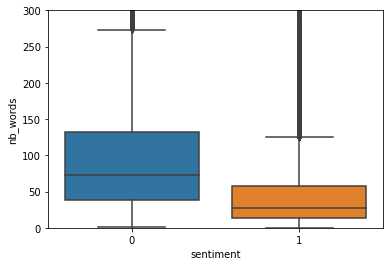

In [25]:
import seaborn as sns
ax = sns.boxplot(x="sentiment", y="nb_words", data=df_french)

ax.set_ylim([0, 300])

# CLEANING

In [85]:
#Remove punctuation on title, content
X_train["title"] = X_train["title"].apply(lambda x : remove_punctuation(x))
X_train["content"] = X_train["content"].apply(lambda x : remove_punctuation(x))


X_test["title"] = X_test["title"].apply(lambda x : remove_punctuation(x))
X_test["content"] = X_test["content"].apply(lambda x : remove_punctuation(x))

In [86]:
#Tokenize/lemmatize title and content - removing stopwords
X_train["title"] = X_train["title"].apply(lambda x : lemmatize(x,nlp,custom_stopwords))
X_train["content"] = X_train["content"].apply(lambda x : lemmatize(x,nlp,custom_stopwords))


X_test["title"] = X_test["title"].apply(lambda x : lemmatize(x,nlp,custom_stopwords))
X_test["content"] = X_test["content"].apply(lambda x : lemmatize(x,nlp,custom_stopwords))

In [92]:
#Spell check words
X_train["title"] = X_train["title"].apply(lambda x : spell_corrector(x,fr_dict))
X_train["content"] = X_train["content"].apply(lambda x : spell_corrector(x,fr_dict))


X_test["title"] = X_test["title"].apply(lambda x : spell_corrector(x,fr_dict))
X_test["content"] = X_test["content"].apply(lambda x : spell_corrector(x,fr_dict))

In [78]:
def dummy(doc):
    return doc

tfidf = CountVectorizer(
    tokenizer=dummy,
    preprocessor=dummy,
    ngram_range=(1,2),
    max_features=5000
)

In [79]:
tfidf = TfidfVectorizer(lowercase=True,
                        ngram_range=(1,2),
                        max_features=5000,
                        stop_words=custom_stopwords
                       )

Document id: 13
Probability(1) = 0.008928445455470741
True class: 1


In [414]:
import spacy

nlp = spacy.load("fr_core_news_sm")
doc = nlp("Il n'est pas un homme.")

for token in doc:
    print(token.text, token.lemma_, token.pos_, token.tag_, token.dep_,
            token.shape_, token.is_alpha, token.is_stop)

Il il PRON PRON__Gender=Masc|Number=Sing|Person=3 nsubj Xx True True
n' n' ADV ADV__Polarity=Neg advmod x' False True
est être AUX AUX__Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin cop xxx True True
pas pas ADV ADV__Polarity=Neg advmod xxx True True
un un DET DET__Definite=Ind|Gender=Masc|Number=Sing|PronType=Art det xx True True
homme homme NOUN NOUN__Gender=Masc|Number=Sing ROOT xxxx True False
. . PUNCT PUNCT___ punct . False False


In [26]:
df_pos = df[df["sentiment"] == 1]

In [27]:
df_pos['length'] = df_pos['content'].apply(lambda x : len(x))

/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
df_pos[df_pos['length'] > 312]

,content,sentiment,length
1,Quand un novice gère son site comme un expert ...,1,427
4,les tarifs et le mailing list dernièrement les...,1,468
6,Très bien c'était ce que je cherche exactement...,1,358
19,Très bien J'ai eu beaucoup de mal à trouver un...,1,323
29,Excellent service Planet Hoster répond rapidem...,1,355
...,...,...,...
19027,Je recommande mais à améliorer ;) Cela fait un...,1,1142
19028,"Très bon service, même pour des utilisateurs d...",1,1374
19032,"Simplicité et réactivité Que dire de plus, un ...",1,338
19033,hébergeur associatif très réactif et d’un très...,1,414


In [49]:
# using camenbert

In [10]:
# Load the BERT tokenizer.
print('Loading CamemBERT tokenizer...')
tokenizer = CamembertTokenizer.from_pretrained("camembert-base", do_lower_case=True)

Loading CamemBERT tokenizer...


In [129]:
config = CamembertConfig(max_position_embeddings=1024)

In [131]:
config

CamembertConfig {
  "architectures": null,
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": null,
  "do_sample": false,
  "eos_token_ids": null,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 1024,
  "model_type": "camembert",
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_layers": 12,
  "num_labels": 2,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_token_id": null,
  "pruned_heads": {},
  "repetition_penalty": 1.0,
  "temperature": 1.0,
  "top_k": 50,
  "top_p": 1.0,
  "torchscript": false,
  "type_vocab_size": 2,
  "use_bfloat16": false,
  

In [11]:
df = df_french[["title","content","sentiment"]]
df["title"].fillna("",inplace=True)
df["content"].fillna("",inplace=True)
df["content"] = df["title"] +" "+ df["content"]
df = df.drop(columns="title").reset_index(drop=True)

/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/pandas/core/generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


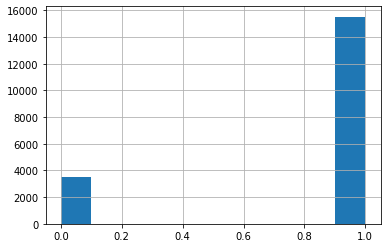

In [12]:
df["sentiment"].hist()

In [13]:
idx = 0

sentences = df['content'].values

# Print the original sentence.
print(' Original: ', sentences[idx])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[idx]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[idx])))

 Original:  Extrêmement bien, rien à redire Ayant acheté 1 an dans ce service, j'en suis extrêmement satisfait, je ne vais pas hésiter à re-commander pour mon futur site !
Tokenized:  ['▁extrêmement', '▁bien', ',', '▁rien', '▁à', '▁redire', '▁ayant', '▁acheté', '▁1', '▁an', '▁dans', '▁ce', '▁service', ',', '▁j', "'", 'en', '▁suis', '▁extrêmement', '▁satisfait', ',', '▁je', '▁ne', '▁vais', '▁pas', '▁hésiter', '▁à', '▁re', '-', 'commande', 'r', '▁pour', '▁mon', '▁futur', '▁site', '▁!']
Token IDs:  [2823, 72, 7, 254, 15, 20155, 634, 2824, 124, 674, 29, 44, 366, 7, 76, 11, 90, 146, 2823, 6639, 7, 50, 45, 676, 34, 13370, 15, 343, 26, 14307, 81, 24, 129, 2025, 132, 83]


In [14]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []

# For every sentence...
for i,sent in enumerate(df['content'].values):
    # `encode` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    print(i)
    encoded_sent = tokenizer.encode(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                        # This function also supports truncation and conversion
                        # to pytorch tensors, but we need to do padding, so we
                        # can't use these features :( .
                        #max_length = 128,          # Truncate all sentences.
                        #return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.
    input_ids.append(encoded_sent)

# Print sentence 0, now as a list of IDs.
print('Original: ', df['content'].values[0])
print('Token IDs:', input_ids[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (940 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (659 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (720 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (1257 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (793 > 512). Running this sequence through the model will result in indexing errors


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063
2064
2065
2066
2067
2068
2069
2070
2071
2072
2073
2074
2075
2076
2077
2078
2079
2080
2081
2082
2083
2084
2085
2086
2087
2088
2089
2090
2091
2092
2093
2094
2095
2096
2097
2098
2099
2100
2101
2102
2103
2104
2105
2106
2107
2108
2109
2110
2111
2112
2113


Token indices sequence length is longer than the specified maximum sequence length for this model (625 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (755 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (580 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (667 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

2311
2312
2313
2314
2315
2316
2317
2318
2319
2320
2321
2322
2323
2324
2325
2326
2327
2328
2329
2330
2331
2332
2333
2334
2335
2336
2337
2338
2339
2340
2341
2342
2343
2344
2345
2346
2347
2348
2349
2350
2351
2352
2353
2354
2355
2356
2357
2358
2359
2360
2361
2362
2363
2364
2365
2366
2367
2368
2369
2370
2371
2372
2373
2374
2375
2376
2377
2378
2379
2380
2381
2382
2383
2384
2385
2386
2387
2388
2389
2390
2391
2392
2393
2394
2395
2396
2397
2398
2399
2400
2401
2402
2403
2404
2405
2406
2407
2408
2409
2410
2411
2412
2413
2414
2415
2416
2417
2418
2419
2420
2421
2422
2423
2424
2425
2426
2427
2428
2429
2430
2431
2432
2433
2434
2435
2436
2437
2438
2439
2440
2441
2442
2443
2444
2445
2446
2447
2448
2449
2450
2451
2452
2453
2454
2455
2456
2457
2458
2459
2460
2461
2462
2463
2464
2465
2466
2467
2468
2469
2470
2471
2472
2473
2474
2475
2476
2477
2478
2479
2480
2481
2482
2483
2484
2485
2486
2487
2488
2489
2490
2491
2492
2493
2494
2495
2496
2497
2498
2499
2500
2501
2502
2503
2504
2505
2506
2507
2508
2509
2510


Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors


2723
2724
2725
2726
2727
2728
2729
2730
2731
2732
2733
2734
2735
2736
2737
2738
2739
2740
2741
2742
2743
2744
2745
2746
2747
2748
2749
2750
2751
2752
2753
2754
2755
2756
2757
2758
2759
2760
2761
2762
2763
2764
2765
2766
2767
2768
2769
2770
2771
2772
2773
2774
2775
2776
2777
2778
2779
2780
2781
2782
2783
2784
2785
2786
2787
2788
2789
2790
2791
2792
2793
2794
2795
2796
2797
2798
2799
2800
2801
2802
2803
2804
2805
2806
2807
2808
2809
2810
2811
2812
2813
2814
2815
2816
2817
2818
2819
2820
2821
2822
2823
2824
2825
2826
2827
2828
2829
2830
2831
2832
2833
2834
2835
2836
2837
2838
2839
2840
2841
2842
2843
2844
2845
2846
2847
2848
2849
2850
2851
2852
2853
2854
2855
2856
2857
2858
2859
2860
2861
2862
2863
2864
2865
2866
2867
2868
2869
2870
2871
2872
2873
2874
2875
2876
2877
2878
2879
2880
2881
2882
2883
2884
2885
2886
2887
2888
2889
2890
2891
2892
2893
2894
2895
2896
2897
2898
2899
2900
2901
2902
2903
2904
2905
2906
2907
2908
2909
2910
2911
2912
2913
2914
2915
2916
2917
2918
2919
2920
2921
2922


Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (736 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi


3101
3102
3103
3104
3105
3106
3107
3108
3109
3110
3111
3112
3113
3114
3115
3116
3117
3118
3119
3120
3121
3122
3123
3124
3125
3126
3127
3128
3129
3130
3131
3132
3133
3134
3135
3136
3137
3138
3139
3140
3141
3142
3143
3144
3145
3146
3147
3148
3149
3150
3151
3152
3153
3154
3155
3156
3157
3158
3159
3160
3161
3162
3163
3164
3165
3166
3167
3168
3169
3170
3171
3172
3173
3174
3175
3176
3177
3178
3179
3180
3181
3182
3183
3184
3185
3186
3187
3188
3189
3190
3191
3192
3193
3194
3195
3196
3197
3198
3199
3200
3201
3202
3203
3204
3205
3206
3207
3208
3209
3210
3211
3212
3213
3214
3215
3216
3217
3218
3219
3220
3221
3222
3223
3224
3225
3226
3227
3228
3229
3230
3231
3232
3233
3234
3235
3236
3237
3238
3239
3240
3241
3242
3243
3244
3245
3246
3247
3248
3249
3250
3251
3252
3253

Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (795 > 512). Running this sequence through the model will result in indexing errors



3254
3255
3256
3257
3258
3259
3260
3261
3262
3263
3264
3265
3266
3267
3268
3269
3270
3271
3272
3273
3274
3275
3276
3277
3278
3279
3280
3281
3282
3283
3284
3285
3286
3287
3288
3289
3290
3291
3292
3293
3294
3295
3296
3297
3298
3299
3300
3301
3302
3303
3304
3305
3306
3307
3308
3309
3310
3311
3312
3313
3314
3315
3316
3317
3318
3319
3320
3321
3322
3323
3324
3325
3326
3327
3328
3329
3330
3331
3332
3333
3334
3335
3336
3337
3338
3339
3340
3341
3342
3343
3344
3345
3346
3347
3348
3349
3350
3351
3352
3353
3354
3355
3356
3357
3358
3359
3360
3361
3362
3363
3364
3365
3366
3367
3368
3369
3370
3371
3372
3373
3374
3375
3376
3377
3378
3379
3380
3381
3382
3383
3384
3385
3386
3387
3388
3389
3390
3391
3392
3393
3394
3395
3396
3397
3398
3399
3400
3401
3402
3403
3404
3405
3406
3407
3408
3409
3410
3411
3412
3413
3414
3415
3416
3417
3418
3419
3420
3421
3422
3423
3424
3425
3426
3427
3428
3429
3430
3431
3432
3433
3434
3435
3436
3437
3438
3439
3440
3441
3442
3443
3444
3445
3446
3447
3448
3449
3450
3451
3452
3453

Token indices sequence length is longer than the specified maximum sequence length for this model (523 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (799 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (549 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi


3488
3489
3490
3491
3492
3493
3494
3495
3496
3497
3498
3499
3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687

Token indices sequence length is longer than the specified maximum sequence length for this model (819 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (525 > 512). Running this sequence through the model will result in indexing errors


3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705
3706
3707
3708
3709
3710
3711
3712
3713
3714
3715
3716
3717
3718
3719
3720
3721
3722
3723
3724
3725
3726
3727
3728
3729
3730
3731
3732
3733
3734
3735
3736
3737
3738
3739
3740
3741
3742
3743
3744
3745
3746
3747
3748
3749
3750
3751
3752
3753
3754
3755
3756
3757
3758
3759
3760
3761
3762
3763
3764
3765
3766
3767
3768
3769
3770
3771
3772
3773
3774
3775
3776
3777
3778
3779
3780
3781
3782
3783
3784
3785
3786
3787
3788
3789
3790
3791
3792
3793
3794
3795
3796
3797
3798
3799
3800
3801
3802
3803
3804
3805
3806
3807
3808
3809
3810
3811
3812
3813
3814
3815
3816
3817
3818
3819
3820
3821
3822
3823
3824
3825
3826
3827
3828
3829
3830
3831
3832
3833
3834
3835
3836
3837
3838
3839
3840
3841
3842
3843
3844
3845
3846
3847
3848
3849
3850
3851
3852
3853
3854
3855
3856
3857
3858
3859
3860
3861
3862
3863
3864
3865
3866
3867
3868
3869
3870
3871
3872
3873
3874
3875
3876
3877
3878
3879
3880
3881
3882
3883
3884
3885
3886
3887
3888
3889
3890
3891
3892


Token indices sequence length is longer than the specified maximum sequence length for this model (646 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (552 > 512). Running this sequence through the model will result in indexing errors


3984
3985
3986
3987
3988
3989
3990
3991
3992
3993
3994
3995
3996
3997
3998
3999
4000
4001
4002
4003
4004
4005
4006
4007
4008
4009
4010
4011
4012
4013
4014
4015
4016
4017
4018
4019
4020
4021
4022
4023
4024
4025
4026
4027
4028
4029
4030
4031
4032
4033
4034
4035
4036
4037
4038
4039
4040
4041
4042
4043
4044
4045
4046
4047
4048
4049
4050
4051
4052
4053
4054
4055
4056
4057
4058
4059
4060
4061
4062
4063
4064
4065
4066
4067
4068
4069
4070
4071
4072
4073
4074
4075
4076
4077
4078
4079
4080
4081
4082
4083
4084
4085
4086
4087
4088
4089
4090
4091
4092
4093
4094
4095
4096
4097
4098
4099
4100
4101
4102
4103
4104
4105
4106
4107
4108
4109
4110
4111
4112
4113
4114
4115
4116
4117
4118
4119
4120
4121
4122
4123
4124
4125
4126
4127
4128
4129
4130
4131
4132
4133
4134
4135
4136
4137
4138
4139
4140
4141
4142
4143
4144
4145
4146
4147
4148
4149
4150
4151
4152
4153
4154
4155
4156
4157
4158
4159
4160
4161
4162
4163
4164
4165
4166
4167
4168
4169
4170
4171
4172
4173
4174
4175
4176
4177
4178
4179
4180
4181
4182
4183


Token indices sequence length is longer than the specified maximum sequence length for this model (790 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (817 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (755 > 512). Running this sequence through the model will result in indexing errors


4396
4397
4398
4399
4400
4401
4402
4403
4404
4405
4406
4407
4408
4409
4410
4411
4412
4413
4414
4415
4416
4417
4418
4419
4420
4421
4422
4423
4424
4425
4426
4427
4428
4429
4430
4431
4432
4433
4434
4435
4436
4437
4438
4439
4440
4441
4442
4443
4444
4445
4446
4447
4448
4449
4450
4451
4452
4453
4454
4455
4456
4457
4458
4459
4460
4461
4462
4463
4464
4465
4466
4467
4468
4469
4470
4471
4472
4473
4474
4475
4476
4477
4478
4479
4480
4481
4482
4483
4484
4485
4486
4487
4488
4489
4490
4491
4492
4493
4494
4495
4496
4497
4498
4499
4500
4501
4502
4503
4504
4505
4506
4507
4508
4509
4510
4511
4512
4513
4514
4515
4516
4517
4518
4519
4520
4521
4522
4523
4524
4525
4526
4527
4528
4529
4530
4531
4532
4533
4534
4535
4536
4537
4538
4539
4540
4541
4542
4543
4544
4545
4546
4547
4548
4549
4550
4551
4552
4553
4554
4555
4556
4557
4558
4559
4560
4561
4562
4563
4564
4565
4566
4567
4568
4569
4570
4571
4572
4573
4574
4575
4576
4577
4578
4579
4580
4581
4582
4583
4584
4585
4586
4587
4588
4589
4590
4591
4592
4593
4594
4595


Token indices sequence length is longer than the specified maximum sequence length for this model (587 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (703 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (566 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (548 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (681 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

4611
4612
4613
4614
4615
4616
4617
4618
4619
4620
4621
4622
4623
4624
4625
4626
4627
4628
4629
4630
4631
4632
4633
4634
4635
4636
4637
4638
4639
4640
4641
4642
4643
4644
4645
4646
4647
4648
4649
4650
4651
4652
4653
4654
4655
4656
4657
4658
4659
4660
4661
4662
4663
4664
4665
4666
4667
4668
4669
4670
4671
4672
4673
4674
4675
4676
4677
4678
4679
4680
4681
4682
4683
4684
4685
4686
4687
4688
4689
4690
4691
4692
4693
4694
4695
4696
4697
4698
4699
4700
4701
4702
4703
4704
4705
4706
4707
4708
4709
4710
4711
4712
4713
4714
4715
4716
4717
4718
4719
4720
4721
4722
4723
4724
4725
4726
4727
4728
4729
4730
4731
4732
4733
4734
4735
4736
4737
4738
4739
4740
4741
4742
4743
4744
4745
4746
4747
4748
4749
4750
4751
4752
4753
4754
4755
4756
4757
4758
4759
4760
4761
4762
4763
4764
4765
4766
4767
4768
4769
4770
4771
4772
4773
4774
4775
4776
4777
4778
4779
4780
4781
4782
4783
4784
4785
4786
4787
4788
4789
4790
4791
4792
4793
4794
4795
4796
4797
4798
4799
4800
4801
4802
4803
4804
4805
4806
4807
4808
4809
4810


Token indices sequence length is longer than the specified maximum sequence length for this model (874 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (592 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (570 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

4902
4903
4904
4905
4906
4907
4908
4909
4910
4911
4912
4913
4914
4915
4916
4917
4918
4919
4920
4921
4922
4923
4924
4925
4926
4927
4928
4929
4930
4931
4932
4933
4934
4935
4936
4937
4938
4939
4940
4941
4942
4943
4944
4945
4946
4947
4948
4949
4950
4951
4952
4953
4954
4955
4956
4957
4958
4959
4960
4961
4962
4963
4964
4965
4966
4967
4968
4969
4970
4971
4972
4973
4974
4975
4976
4977
4978
4979
4980
4981
4982
4983
4984
4985
4986
4987
4988
4989
4990
4991
4992
4993
4994
4995
4996
4997
4998
4999
5000
5001
5002
5003
5004
5005
5006
5007
5008
5009
5010
5011
5012
5013
5014
5015
5016
5017
5018
5019
5020
5021
5022
5023
5024
5025
5026
5027
5028
5029
5030
5031
5032
5033
5034
5035
5036
5037
5038
5039
5040
5041
5042
5043
5044
5045
5046
5047
5048
5049
5050
5051
5052
5053
5054
5055
5056
5057
5058
5059
5060
5061
5062
5063
5064
5065
5066
5067
5068
5069
5070
5071
5072
5073
5074
5075
5076
5077
5078
5079
5080
5081
5082
5083
5084
5085
5086
5087
5088
5089
5090
5091
5092
5093
5094


Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (546 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (512 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (794 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

5095
5096
5097
5098
5099
5100
5101
5102
5103
5104
5105
5106
5107
5108
5109
5110
5111
5112
5113
5114
5115
5116
5117
5118
5119
5120
5121
5122
5123
5124
5125
5126
5127
5128
5129
5130
5131
5132
5133
5134
5135
5136
5137
5138
5139
5140
5141
5142
5143
5144
5145
5146
5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294


Token indices sequence length is longer than the specified maximum sequence length for this model (588 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (568 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (915 > 512). Running this sequence through the model will result in indexing errors


5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346
5347
5348
5349
5350
5351
5352
5353
5354
5355
5356
5357
5358
5359
5360
5361
5362
5363
5364
5365
5366
5367
5368
5369
5370
5371
5372
5373
5374
5375
5376
5377
5378
5379
5380
5381
5382
5383
5384
5385
5386
5387
5388
5389
5390
5391
5392
5393
5394
5395
5396
5397
5398
5399
5400
5401
5402
5403
5404
5405
5406
5407
5408
5409
5410
5411
5412
5413
5414
5415
5416
5417
5418
5419
5420
5421
5422
5423
5424
5425
5426
5427
5428
5429
5430
5431
5432
5433
5434
5435
5436
5437
5438
5439
5440
5441
5442
5443
5444
5445
5446
5447
5448
5449
5450
5451
5452
5453
5454
5455
5456
5457
5458
5459
5460
5461
5462
5463
5464
5465
5466
5467
5468
5469
5470
5471
5472
5473
5474
5475
5476
5477
5478
5479
5480
5481

Token indices sequence length is longer than the specified maximum sequence length for this model (894 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (599 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (745 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (539 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (982 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi


5482
5483
5484
5485
5486
5487
5488
5489
5490
5491
5492
5493
5494
5495
5496
5497
5498
5499
5500
5501
5502
5503
5504
5505
5506
5507
5508
5509
5510
5511
5512
5513
5514
5515
5516
5517
5518
5519
5520
5521
5522
5523
5524
5525
5526
5527
5528
5529
5530
5531
5532
5533
5534
5535
5536
5537
5538
5539
5540
5541
5542
5543
5544
5545
5546
5547
5548
5549
5550
5551
5552
5553
5554
5555
5556
5557
5558
5559
5560
5561
5562
5563
5564
5565
5566
5567
5568
5569
5570
5571
5572
5573
5574
5575
5576
5577
5578
5579
5580
5581
5582
5583
5584
5585
5586
5587
5588
5589
5590
5591
5592
5593
5594
5595
5596
5597
5598
5599
5600
5601
5602
5603
5604
5605
5606
5607
5608
5609
5610
5611
5612
5613
5614
5615
5616
5617
5618
5619
5620
5621
5622
5623
5624
5625


Token indices sequence length is longer than the specified maximum sequence length for this model (547 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (673 > 512). Running this sequence through the model will result in indexing errors


5626
5627
5628
5629
5630
5631
5632
5633
5634
5635
5636
5637
5638
5639
5640
5641
5642
5643
5644
5645
5646
5647
5648
5649
5650
5651
5652
5653
5654
5655
5656
5657
5658
5659
5660
5661
5662
5663
5664
5665
5666
5667
5668
5669
5670
5671
5672
5673
5674
5675
5676
5677
5678
5679
5680
5681
5682
5683
5684
5685
5686
5687
5688
5689
5690
5691
5692
5693
5694
5695
5696
5697
5698
5699
5700
5701
5702
5703
5704
5705
5706
5707
5708
5709
5710
5711
5712
5713
5714
5715
5716
5717
5718
5719
5720
5721
5722
5723
5724
5725
5726
5727
5728
5729
5730
5731
5732
5733
5734
5735
5736
5737
5738
5739
5740
5741
5742
5743
5744
5745
5746
5747
5748
5749
5750
5751
5752
5753
5754
5755
5756
5757
5758
5759
5760
5761
5762
5763
5764
5765
5766
5767
5768
5769
5770
5771
5772
5773
5774
5775
5776
5777
5778
5779
5780
5781
5782
5783
5784
5785
5786
5787
5788
5789
5790
5791
5792
5793
5794
5795
5796
5797
5798
5799
5800
5801
5802
5803
5804
5805
5806
5807
5808
5809
5810
5811
5812
5813
5814
5815
5816
5817
5818
5819
5820
5821
5822
5823
5824
5825


Token indices sequence length is longer than the specified maximum sequence length for this model (825 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (674 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (682 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (723 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi


5871
5872
5873
5874
5875
5876
5877
5878
5879
5880
5881
5882
5883
5884
5885
5886
5887
5888
5889
5890
5891
5892
5893
5894
5895
5896
5897
5898
5899
5900
5901
5902
5903
5904
5905
5906
5907
5908
5909
5910
5911
5912
5913
5914
5915
5916
5917
5918
5919
5920
5921
5922
5923
5924
5925
5926
5927
5928
5929
5930
5931
5932
5933
5934
5935
5936
5937
5938
5939
5940
5941
5942
5943
5944
5945
5946
5947
5948
5949
5950
5951
5952
5953
5954
5955
5956
5957
5958
5959
5960
5961
5962
5963
5964
5965
5966
5967
5968
5969
5970
5971
5972
5973
5974
5975
5976
5977
5978
5979
5980
5981
5982
5983
5984
5985
5986
5987
5988
5989
5990
5991
5992
5993
5994
5995
5996
5997
5998
5999
6000
6001
6002
6003
6004
6005
6006
6007
6008
6009
6010
6011
6012
6013
6014
6015
6016
6017
6018
6019
6020
6021
6022
6023
6024
6025
6026
6027
6028
6029
6030
6031
6032
6033
6034
6035
6036
6037
6038
6039
6040
6041
6042
6043
6044
6045
6046
6047
6048
6049
6050
6051
6052
6053
6054
6055
6056
6057
6058
6059
6060
6061
6062
6063
6064
6065
6066
6067
6068
6069
6070

Token indices sequence length is longer than the specified maximum sequence length for this model (743 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (537 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (690 > 512). Running this sequence through the model will result in indexing errors


6133
6134
6135
6136
6137
6138
6139
6140
6141
6142
6143
6144
6145
6146
6147
6148
6149
6150
6151
6152
6153
6154
6155
6156
6157
6158
6159
6160
6161
6162
6163
6164
6165
6166
6167
6168
6169
6170
6171
6172
6173
6174
6175
6176
6177
6178
6179
6180
6181
6182
6183
6184
6185
6186
6187
6188
6189
6190
6191
6192
6193
6194
6195
6196
6197
6198
6199
6200
6201
6202
6203
6204
6205
6206
6207
6208
6209
6210
6211
6212
6213
6214
6215
6216
6217
6218
6219
6220
6221
6222
6223
6224
6225
6226
6227
6228
6229
6230
6231
6232
6233
6234
6235
6236
6237
6238
6239
6240
6241
6242
6243
6244
6245
6246
6247
6248
6249
6250
6251
6252
6253
6254
6255
6256
6257
6258
6259
6260
6261
6262
6263
6264
6265
6266
6267
6268
6269
6270
6271
6272
6273
6274
6275
6276
6277
6278
6279
6280
6281
6282
6283
6284
6285
6286
6287
6288
6289
6290
6291
6292
6293
6294
6295
6296
6297
6298
6299
6300
6301
6302
6303
6304
6305
6306
6307
6308
6309
6310
6311
6312
6313
6314
6315
6316
6317
6318
6319
6320
6321
6322
6323
6324
6325
6326
6327
6328
6329
6330
6331
6332


Token indices sequence length is longer than the specified maximum sequence length for this model (987 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (639 > 512). Running this sequence through the model will result in indexing errors



6354
6355
6356
6357
6358
6359
6360
6361
6362
6363
6364
6365
6366
6367
6368
6369
6370
6371
6372
6373
6374
6375
6376
6377
6378
6379
6380
6381
6382
6383
6384
6385
6386
6387
6388
6389
6390
6391
6392
6393
6394
6395
6396
6397
6398
6399
6400
6401
6402
6403
6404
6405
6406
6407
6408
6409
6410
6411
6412
6413
6414
6415
6416
6417
6418
6419
6420
6421
6422
6423
6424
6425
6426
6427
6428
6429
6430
6431
6432
6433
6434
6435
6436
6437
6438
6439
6440
6441
6442
6443
6444
6445
6446
6447
6448
6449
6450
6451
6452
6453
6454
6455
6456
6457
6458
6459
6460
6461
6462
6463
6464
6465
6466
6467
6468
6469
6470
6471
6472
6473
6474
6475
6476
6477
6478
6479
6480
6481
6482
6483
6484
6485
6486
6487
6488
6489
6490
6491
6492
6493
6494
6495
6496
6497
6498
6499
6500
6501
6502
6503
6504
6505
6506
6507
6508
6509
6510
6511
6512
6513
6514
6515
6516
6517
6518
6519
6520
6521
6522
6523
6524
6525
6526
6527
6528
6529
6530
6531
6532
6533
6534
6535
6536
6537
6538
6539
6540
6541
6542
6543
6544
6545
6546
6547
6548
6549
6550
6551
6552
6553

Token indices sequence length is longer than the specified maximum sequence length for this model (577 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (519 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (744 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (615 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (637 > 512). Running this sequence through the model will result in indexing errors


6726
6727
6728
6729
6730
6731
6732
6733
6734
6735
6736
6737
6738
6739
6740
6741
6742
6743
6744
6745
6746
6747
6748
6749
6750
6751
6752
6753
6754
6755
6756
6757
6758
6759
6760
6761
6762
6763
6764
6765
6766
6767
6768
6769
6770
6771
6772
6773
6774
6775
6776
6777
6778
6779
6780
6781
6782
6783
6784
6785
6786
6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925


Token indices sequence length is longer than the specified maximum sequence length for this model (829 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (560 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors


6984
6985
6986
6987
6988
6989
6990
6991
6992
6993
6994
6995
6996
6997
6998
6999
7000
7001
7002
7003
7004
7005
7006
7007
7008
7009
7010
7011
7012
7013
7014
7015
7016
7017
7018
7019
7020
7021
7022
7023
7024
7025
7026
7027
7028
7029
7030
7031
7032
7033
7034
7035
7036
7037
7038
7039
7040
7041
7042
7043
7044
7045
7046
7047
7048
7049
7050
7051
7052
7053
7054
7055
7056
7057
7058
7059
7060
7061
7062
7063
7064
7065
7066
7067
7068
7069
7070
7071
7072
7073
7074
7075
7076
7077
7078
7079
7080
7081
7082
7083
7084
7085
7086
7087
7088
7089
7090
7091
7092
7093
7094
7095
7096
7097
7098
7099
7100
7101
7102
7103
7104
7105
7106
7107
7108
7109
7110
7111
7112
7113
7114
7115
7116
7117
7118
7119
7120
7121
7122
7123
7124
7125
7126
7127
7128
7129
7130
7131
7132
7133
7134
7135
7136
7137
7138
7139
7140
7141
7142
7143
7144
7145
7146
7147
7148
7149
7150
7151
7152
7153
7154
7155
7156
7157
7158
7159
7160
7161
7162
7163
7164
7165
7166
7167
7168
7169
7170
7171
7172
7173
7174
7175
7176
7177
7178
7179
7180
7181
7182
7183


Token indices sequence length is longer than the specified maximum sequence length for this model (642 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (635 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (614 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (594 > 512). Running this sequence through the model will result in indexing errors


7285
7286
7287
7288
7289
7290
7291
7292
7293
7294
7295
7296
7297
7298
7299
7300
7301
7302
7303
7304
7305
7306
7307
7308
7309
7310
7311
7312
7313
7314
7315
7316
7317
7318
7319
7320
7321
7322
7323
7324
7325
7326
7327
7328
7329
7330
7331
7332
7333
7334
7335
7336
7337
7338
7339
7340
7341
7342
7343
7344
7345
7346
7347
7348
7349
7350
7351
7352
7353
7354
7355
7356
7357
7358
7359
7360
7361
7362
7363
7364
7365
7366
7367
7368
7369
7370
7371
7372
7373
7374
7375
7376
7377
7378
7379
7380
7381
7382
7383
7384
7385
7386
7387
7388
7389
7390
7391
7392
7393
7394
7395
7396
7397
7398
7399
7400
7401
7402
7403
7404
7405
7406
7407
7408
7409
7410
7411
7412
7413
7414
7415
7416
7417
7418
7419
7420
7421
7422
7423
7424
7425
7426
7427
7428
7429
7430
7431
7432
7433
7434
7435
7436
7437
7438
7439
7440
7441
7442
7443
7444
7445
7446
7447
7448
7449
7450
7451
7452
7453
7454
7455
7456
7457
7458
7459
7460
7461
7462
7463
7464
7465
7466
7467
7468
7469
7470
7471
7472
7473
7474
7475
7476
7477
7478
7479
7480
7481
7482
7483
7484


Token indices sequence length is longer than the specified maximum sequence length for this model (596 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (551 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (521 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (864 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (586 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

7586
7587
7588
7589
7590
7591
7592
7593
7594
7595
7596
7597
7598
7599
7600
7601
7602
7603
7604
7605
7606
7607
7608
7609
7610
7611
7612
7613
7614
7615
7616
7617
7618
7619
7620
7621
7622
7623
7624
7625
7626
7627
7628
7629
7630
7631
7632
7633
7634
7635
7636
7637
7638
7639
7640
7641
7642
7643
7644
7645
7646
7647
7648
7649
7650
7651
7652
7653
7654
7655
7656
7657
7658
7659
7660
7661
7662
7663
7664
7665
7666
7667
7668
7669
7670
7671
7672
7673
7674
7675
7676
7677
7678
7679
7680
7681
7682
7683
7684
7685
7686
7687
7688
7689
7690
7691
7692
7693
7694
7695
7696
7697
7698
7699
7700
7701
7702
7703
7704
7705
7706
7707
7708
7709
7710
7711
7712
7713
7714
7715
7716
7717
7718
7719
7720
7721
7722
7723
7724
7725
7726
7727
7728
7729
7730
7731
7732
7733
7734
7735
7736
7737
7738
7739
7740
7741
7742
7743
7744
7745
7746
7747
7748
7749
7750
7751
7752
7753
7754
7755
7756
7757
7758
7759
7760
7761
7762
7763
7764
7765
7766
7767
7768
7769
7770
7771
7772
7773
7774
7775
7776
7777
7778
7779
7780
7781
7782
7783
7784
7785


Token indices sequence length is longer than the specified maximum sequence length for this model (543 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (771 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (796 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (565 > 512). Running this sequence through the model will result in indexing errors


7794
7795
7796
7797
7798
7799
7800
7801
7802
7803
7804
7805
7806
7807
7808
7809
7810
7811
7812
7813
7814
7815
7816
7817
7818
7819
7820
7821
7822
7823
7824
7825
7826
7827
7828
7829
7830
7831
7832
7833
7834
7835
7836
7837
7838
7839
7840
7841
7842
7843
7844
7845
7846
7847
7848
7849
7850
7851
7852
7853
7854
7855
7856
7857
7858
7859
7860
7861
7862
7863
7864
7865
7866
7867
7868
7869
7870
7871
7872
7873
7874
7875
7876
7877
7878
7879
7880
7881
7882
7883
7884
7885
7886
7887
7888
7889
7890
7891
7892
7893
7894
7895
7896
7897
7898
7899
7900
7901
7902
7903
7904
7905
7906
7907
7908
7909
7910
7911
7912
7913
7914
7915
7916
7917
7918
7919
7920
7921
7922
7923
7924
7925
7926
7927
7928
7929
7930
7931
7932
7933
7934
7935
7936
7937
7938
7939
7940
7941
7942
7943
7944
7945
7946
7947
7948
7949
7950
7951
7952
7953
7954
7955
7956
7957
7958
7959
7960
7961
7962
7963
7964
7965
7966
7967
7968
7969
7970
7971
7972
7973
7974
7975
7976
7977
7978
7979
7980
7981
7982
7983
7984
7985
7986
7987
7988
7989
7990
7991
7992
7993


Token indices sequence length is longer than the specified maximum sequence length for this model (761 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (750 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (718 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (737 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (569 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

8096
8097
8098
8099
8100
8101
8102
8103
8104
8105
8106
8107
8108
8109
8110
8111
8112
8113
8114
8115
8116
8117
8118
8119
8120
8121
8122
8123
8124
8125
8126
8127
8128
8129
8130
8131
8132
8133
8134
8135
8136
8137
8138
8139
8140
8141
8142
8143
8144
8145
8146
8147
8148
8149
8150
8151
8152
8153
8154
8155
8156
8157
8158
8159
8160
8161
8162
8163
8164
8165
8166
8167
8168
8169
8170
8171
8172
8173
8174
8175
8176
8177
8178
8179
8180
8181
8182
8183
8184
8185
8186
8187
8188
8189
8190
8191
8192
8193
8194
8195
8196
8197
8198
8199
8200
8201
8202
8203
8204
8205
8206
8207
8208
8209
8210
8211
8212
8213
8214
8215
8216
8217
8218
8219
8220
8221
8222
8223
8224
8225
8226
8227
8228


Token indices sequence length is longer than the specified maximum sequence length for this model (515 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (524 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (768 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (684 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (679 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

8229
8230
8231
8232
8233
8234
8235
8236
8237
8238
8239
8240
8241
8242
8243
8244
8245
8246
8247
8248
8249
8250
8251
8252
8253
8254
8255
8256
8257
8258
8259
8260
8261
8262
8263
8264
8265
8266
8267
8268
8269
8270
8271
8272
8273
8274
8275
8276
8277
8278
8279
8280
8281
8282
8283
8284
8285
8286
8287
8288
8289
8290
8291
8292
8293
8294
8295
8296
8297
8298
8299
8300
8301
8302
8303
8304
8305
8306
8307
8308
8309
8310
8311
8312
8313
8314
8315
8316
8317
8318
8319
8320
8321
8322
8323
8324
8325
8326
8327
8328
8329
8330
8331
8332
8333
8334
8335
8336
8337
8338
8339
8340
8341
8342
8343
8344
8345
8346
8347
8348
8349
8350
8351
8352
8353
8354
8355
8356
8357
8358
8359
8360
8361
8362
8363
8364
8365
8366
8367
8368
8369
8370
8371
8372
8373
8374
8375
8376
8377
8378
8379
8380
8381
8382
8383
8384
8385
8386
8387
8388
8389
8390
8391
8392
8393
8394
8395
8396
8397
8398
8399
8400
8401
8402
8403
8404
8405
8406
8407
8408
8409
8410
8411
8412
8413
8414
8415
8416
8417
8418
8419
8420
8421
8422
8423
8424
8425
8426
8427
8428


Token indices sequence length is longer than the specified maximum sequence length for this model (727 > 512). Running this sequence through the model will result in indexing errors


8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626
8627
8628
8629
8630
8631
8632
8633
8634
8635
8636
8637
8638
8639
8640
8641
8642
8643
8644
8645
8646
8647
8648
8649
8650
8651
8652
8653
8654
8655
8656
8657
8658
8659
8660
8661
8662
8663
8664
8665
8666
8667
8668
8669
8670
8671
8672
8673
8674
8675
8676
8677
8678
8679
8680
8681
8682
8683
8684
8685
8686
8687
8688
8689
8690
8691
8692
8693
8694
8695
8696
8697
8698
8699
8700
8701
8702
8703


Token indices sequence length is longer than the specified maximum sequence length for this model (1055 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (834 > 512). Running this sequence through the model will result in indexing errors


9392
9393
9394
9395
9396
9397
9398
9399
9400
9401
9402
9403
9404
9405
9406
9407
9408
9409
9410
9411
9412
9413
9414
9415
9416
9417
9418
9419
9420
9421
9422
9423
9424
9425
9426
9427
9428
9429
9430
9431
9432
9433
9434
9435
9436
9437
9438
9439
9440
9441
9442
9443
9444
9445
9446
9447
9448
9449
9450
9451
9452
9453
9454
9455
9456
9457
9458
9459
9460
9461
9462
9463
9464
9465
9466
9467
9468
9469
9470
9471
9472
9473
9474
9475
9476
9477
9478
9479
9480
9481
9482
9483
9484
9485
9486
9487
9488
9489
9490
9491
9492
9493
9494
9495
9496
9497
9498
9499
9500
9501
9502
9503
9504
9505
9506
9507
9508
9509
9510
9511
9512
9513
9514
9515
9516
9517
9518
9519
9520
9521
9522
9523
9524
9525
9526
9527
9528
9529
9530
9531
9532
9533
9534
9535
9536
9537
9538
9539
9540
9541
9542
9543
9544
9545
9546
9547
9548
9549
9550
9551
9552
9553
9554
9555
9556
9557
9558
9559
9560
9561
9562
9563
9564
9565
9566
9567
9568
9569
9570
9571
9572
9573
9574
9575
9576
9577
9578
9579
9580
9581
9582
9583
9584
9585
9586
9587
9588
9589
9590
9591


Token indices sequence length is longer than the specified maximum sequence length for this model (939 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors


9853
9854
9855
9856
9857
9858
9859
9860
9861
9862
9863
9864
9865
9866
9867
9868
9869
9870
9871
9872
9873
9874
9875
9876
9877
9878
9879
9880
9881
9882
9883
9884
9885
9886
9887
9888
9889
9890
9891
9892
9893
9894
9895
9896
9897
9898
9899
9900
9901
9902
9903
9904
9905
9906
9907
9908
9909
9910
9911
9912
9913
9914
9915
9916
9917
9918
9919
9920
9921
9922
9923
9924
9925
9926
9927
9928
9929
9930
9931
9932
9933
9934
9935
9936
9937
9938
9939
9940
9941
9942
9943
9944
9945
9946
9947
9948
9949
9950
9951
9952
9953
9954
9955
9956
9957
9958
9959
9960
9961
9962
9963
9964
9965
9966
9967
9968
9969
9970
9971
9972
9973
9974
9975
9976
9977
9978
9979
9980
9981
9982
9983
9984
9985
9986
9987
9988
9989
9990
9991
9992
9993
9994
9995
9996
9997
9998
9999
10000
10001
10002
10003
10004
10005
10006
10007
10008
10009
10010
10011
10012
10013
10014
10015
10016
10017
10018
10019
10020
10021
10022
10023
10024
10025
10026
10027
10028
10029
10030
10031
10032
10033
10034
10035
10036
10037
10038
10039
10040
10041
10042
10043
1

Token indices sequence length is longer than the specified maximum sequence length for this model (590 > 512). Running this sequence through the model will result in indexing errors


10339
10340
10341
10342
10343
10344
10345
10346
10347
10348
10349
10350
10351
10352
10353
10354
10355
10356
10357
10358
10359
10360
10361
10362
10363
10364
10365
10366
10367
10368
10369
10370
10371
10372
10373
10374
10375
10376
10377
10378
10379
10380
10381
10382
10383
10384
10385
10386
10387
10388
10389
10390
10391
10392
10393
10394
10395
10396
10397
10398
10399
10400
10401
10402
10403
10404
10405
10406
10407
10408
10409
10410
10411
10412
10413
10414
10415
10416
10417
10418
10419
10420
10421
10422
10423
10424
10425
10426
10427
10428
10429
10430
10431
10432
10433
10434
10435
10436
10437
10438
10439
10440
10441
10442
10443
10444
10445
10446
10447
10448
10449
10450
10451
10452
10453
10454
10455
10456
10457
10458
10459
10460
10461
10462
10463
10464
10465
10466
10467
10468
10469
10470
10471
10472
10473
10474
10475
10476
10477
10478
10479
10480
10481
10482
10483
10484
10485
10486
10487
10488
10489
10490
10491
10492
10493
10494
10495
10496
10497
10498
10499
10500
10501
10502
10503
10504
1050

Token indices sequence length is longer than the specified maximum sequence length for this model (561 > 512). Running this sequence through the model will result in indexing errors


11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
11589
11590
11591
11592
11593
11594
11595
11596
11597
11598
11599
11600
11601
11602
11603
11604
11605
11606
11607
11608
11609
11610
11611
11612
11613
11614
11615
11616
11617
11618
11619
11620
11621
11622
11623
11624
11625
11626
11627
11628
11629
11630
11631
11632
11633
11634
11635
11636
11637
11638
11639
11640
11641
11642
11643
11644
11645
11646
11647
11648
11649
11650
11651
11652
11653
11654
11655
11656
11657
11658
11659
11660
11661
11662
11663
11664
11665
11666
11667
11668
11669
11670
11671
11672
11673
11674
11675
11676
11677
11678
11679
11680
11681
11682
11683
11684
11685
11686
11687
11688
11689
11690
11691
11692
1169

Token indices sequence length is longer than the specified maximum sequence length for this model (607 > 512). Running this sequence through the model will result in indexing errors


12130
12131
12132
12133
12134
12135
12136
12137
12138
12139
12140
12141
12142
12143
12144
12145
12146
12147
12148
12149
12150
12151
12152
12153
12154
12155
12156
12157
12158
12159
12160
12161
12162
12163
12164
12165
12166
12167
12168
12169
12170
12171
12172
12173
12174
12175
12176
12177
12178
12179
12180
12181
12182
12183
12184
12185
12186
12187
12188
12189
12190
12191
12192
12193
12194
12195
12196
12197
12198
12199
12200
12201
12202
12203
12204
12205
12206
12207
12208
12209
12210
12211
12212
12213
12214
12215
12216
12217
12218
12219
12220
12221
12222
12223
12224
12225
12226
12227
12228
12229
12230
12231
12232
12233
12234
12235
12236
12237
12238
12239
12240
12241
12242
12243
12244
12245
12246
12247
12248
12249
12250
12251
12252
12253
12254
12255
12256
12257
12258
12259
12260
12261
12262
12263
12264
12265
12266
12267
12268
12269
12270
12271
12272
12273
12274
12275
12276
12277
12278
12279
12280
12281
12282
12283
12284
12285
12286
12287
12288
12289
12290
12291
12292
12293
12294
12295
1229

Token indices sequence length is longer than the specified maximum sequence length for this model (722 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (533 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (2271 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (818 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (782 > 512). Running this sequence through the model will result in indexing errors


12557
12558
12559
12560
12561
12562
12563
12564
12565
12566
12567
12568
12569
12570
12571
12572
12573
12574
12575
12576
12577
12578
12579
12580
12581
12582
12583
12584
12585
12586
12587
12588
12589
12590
12591
12592
12593
12594
12595
12596
12597
12598
12599
12600
12601
12602
12603
12604
12605
12606
12607
12608
12609
12610
12611
12612
12613
12614
12615
12616
12617
12618
12619
12620
12621
12622
12623
12624
12625
12626
12627
12628
12629
12630
12631
12632
12633
12634
12635
12636
12637
12638
12639
12640
12641
12642
12643
12644
12645
12646
12647
12648
12649
12650
12651
12652
12653
12654
12655
12656
12657
12658
12659
12660
12661
12662
12663
12664
12665
12666
12667
12668
12669
12670
12671
12672
12673
12674
12675
12676
12677
12678
12679
12680
12681
12682
12683
12684
12685
12686
12687
12688
12689
12690
12691
12692
12693
12694
12695
12696
12697
12698
12699
12700
12701
12702
12703
12704
12705
12706
12707
12708
12709
12710
12711
12712
12713
12714
12715
12716
12717
12718
12719
12720
12721
12722
1272

Token indices sequence length is longer than the specified maximum sequence length for this model (511 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (956 > 512). Running this sequence through the model will result in indexing errors



12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
12957
12958
12959
12960
12961
12962
12963
12964
12965
12966
12967
12968
12969
12970
12971
12972
12973
12974
12975
12976
12977
12978
12979
12980
12981
12982
12983
12984
12985
12986
12987
12988
12989
12990
12991
12992
12993
12994
12995
12996
12997
12998
12999
13000
13001
13002
13003
13004
13005
130

Token indices sequence length is longer than the specified maximum sequence length for this model (822 > 512). Running this sequence through the model will result in indexing errors


13134
13135
13136
13137
13138
13139
13140
13141
13142
13143
13144
13145
13146
13147
13148
13149
13150
13151
13152
13153
13154
13155
13156
13157
13158
13159
13160
13161
13162
13163
13164
13165
13166
13167
13168
13169
13170
13171
13172
13173
13174
13175
13176
13177
13178
13179
13180
13181
13182
13183
13184
13185
13186
13187
13188
13189
13190
13191
13192
13193
13194
13195
13196
13197
13198
13199
13200
13201
13202
13203
13204
13205
13206
13207
13208
13209
13210
13211
13212
13213
13214
13215
13216
13217
13218
13219
13220
13221
13222
13223
13224
13225
13226
13227
13228
13229
13230
13231
13232
13233
13234
13235
13236
13237
13238
13239
13240
13241
13242
13243
13244
13245
13246
13247
13248
13249
13250
13251
13252
13253
13254
13255
13256
13257
13258
13259
13260
13261
13262
13263
13264
13265
13266
13267
13268
13269
13270
13271
13272
13273
13274
13275
13276
13277
13278
13279
13280
13281
13282
13283
13284
13285
13286
13287
13288
13289
13290
13291
13292
13293
13294
13295
13296
13297
13298
13299
1330

Token indices sequence length is longer than the specified maximum sequence length for this model (949 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (706 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (598 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (685 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi


13564
13565
13566
13567
13568
13569
13570
13571
13572
13573
13574
13575
13576
13577
13578
13579
13580
13581
13582
13583
13584
13585
13586
13587
13588
13589
13590
13591
13592
13593
13594
13595
13596
13597
13598
13599
13600
13601
13602
13603
13604
13605
13606
13607
13608
13609
13610
13611
13612
13613
13614
13615
13616
13617
13618
13619
13620
13621
13622
13623
13624
13625
13626
13627
13628
13629
13630
13631
13632
13633
13634
13635
13636
13637
13638
13639
13640
13641
13642
13643
13644
13645
13646
13647
13648
13649
13650
13651
13652
13653
13654
13655
13656
13657
13658
13659
13660
13661
13662
13663
13664
13665
13666
13667
13668
13669
13670
13671
13672
13673
13674
13675
13676
13677
13678
13679
13680
13681
13682
13683
13684
13685
13686
13687
13688
13689
13690
13691
13692
13693
13694
13695
13696
13697
13698
13699
13700
13701
13702
13703
13704
13705
13706
13707
13708
13709
13710
13711
13712
13713
13714
13715
13716
13717
13718
13719
13720
13721
13722
13723
13724
13725
13726
13727
13728
13729
137

Token indices sequence length is longer than the specified maximum sequence length for this model (657 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (608 > 512). Running this sequence through the model will result in indexing errors


13758
13759
13760
13761
13762
13763
13764
13765
13766
13767
13768
13769
13770
13771
13772
13773
13774
13775
13776
13777
13778
13779
13780
13781
13782
13783
13784
13785
13786
13787
13788
13789
13790
13791
13792
13793
13794
13795
13796
13797
13798
13799
13800
13801
13802
13803
13804
13805
13806
13807
13808
13809
13810
13811
13812
13813
13814
13815
13816
13817
13818
13819
13820
13821
13822
13823
13824
13825
13826
13827
13828
13829
13830
13831
13832
13833
13834
13835
13836
13837
13838
13839
13840
13841
13842
13843
13844
13845
13846
13847
13848
13849
13850
13851
13852
13853
13854
13855
13856
13857
13858
13859
13860
13861
13862
13863
13864
13865
13866
13867
13868
13869
13870
13871
13872
13873
13874
13875
13876
13877
13878
13879
13880
13881
13882
13883
13884
13885
13886
13887
13888
13889
13890
13891
13892
13893
13894
13895
13896
13897
13898
13899
13900
13901
13902
13903
13904
13905
13906
13907
13908
13909
13910
13911
13912
13913
13914
13915
13916
13917
13918
13919
13920
13921
13922
13923
1392

Token indices sequence length is longer than the specified maximum sequence length for this model (618 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (803 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (684 > 512). Running this sequence through the model will result in indexing errors


14032
14033
14034
14035
14036
14037
14038
14039
14040
14041
14042
14043
14044
14045
14046
14047
14048
14049
14050
14051
14052
14053
14054
14055
14056
14057
14058
14059
14060
14061
14062
14063
14064
14065
14066
14067
14068
14069
14070
14071
14072
14073
14074
14075
14076
14077
14078
14079
14080
14081
14082
14083
14084
14085
14086
14087
14088
14089
14090
14091
14092
14093
14094
14095
14096
14097
14098
14099
14100
14101
14102
14103
14104
14105
14106
14107
14108
14109
14110
14111
14112
14113
14114
14115
14116
14117
14118
14119
14120
14121
14122
14123
14124
14125
14126
14127
14128
14129
14130
14131
14132
14133
14134
14135
14136
14137
14138
14139
14140
14141
14142
14143
14144
14145
14146
14147
14148
14149
14150
14151
14152
14153
14154
14155
14156
14157
14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
1419

Token indices sequence length is longer than the specified maximum sequence length for this model (622 > 512). Running this sequence through the model will result in indexing errors


14565
14566
14567
14568
14569
14570
14571
14572
14573
14574
14575
14576
14577
14578
14579
14580
14581
14582
14583
14584
14585
14586
14587
14588
14589
14590
14591
14592
14593
14594
14595
14596
14597
14598
14599
14600
14601
14602
14603
14604
14605
14606
14607
14608
14609
14610
14611
14612
14613
14614
14615
14616
14617
14618
14619
14620
14621
14622
14623
14624
14625
14626
14627
14628
14629
14630
14631
14632
14633
14634
14635
14636
14637
14638
14639
14640
14641
14642
14643
14644
14645
14646
14647
14648
14649
14650
14651
14652
14653
14654
14655
14656
14657
14658
14659
14660
14661
14662
14663
14664
14665
14666
14667
14668
14669
14670
14671
14672
14673
14674
14675
14676
14677
14678
14679
14680
14681
14682
14683
14684
14685
14686
14687
14688
14689
14690
14691
14692
14693
14694
14695
14696
14697
14698
14699
14700
14701
14702
14703
14704
14705
14706
14707
14708
14709
14710
14711
14712
14713
14714
14715
14716
14717
14718
14719
14720
14721
14722
14723
14724
14725
14726
14727
14728
14729
14730
1473

Token indices sequence length is longer than the specified maximum sequence length for this model (871 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (822 > 512). Running this sequence through the model will result in indexing errors


14908
14909
14910
14911
14912
14913
14914
14915
14916
14917
14918
14919
14920
14921
14922
14923
14924
14925
14926
14927
14928
14929
14930
14931
14932
14933
14934
14935
14936
14937
14938
14939
14940
14941
14942
14943
14944
14945
14946
14947
14948
14949
14950
14951
14952
14953
14954
14955
14956
14957
14958
14959
14960
14961
14962
14963
14964
14965
14966
14967
14968
14969
14970
14971
14972
14973
14974
14975
14976
14977
14978
14979
14980
14981
14982
14983
14984
14985
14986
14987
14988
14989
14990
14991
14992
14993
14994
14995
14996
14997
14998
14999
15000
15001
15002
15003
15004
15005
15006
15007
15008
15009
15010
15011
15012
15013
15014
15015
15016
15017
15018
15019
15020
15021
15022
15023
15024
15025
15026
15027
15028
15029
15030
15031
15032
15033
15034
15035
15036
15037
15038
15039
15040
15041
15042
15043
15044
15045
15046
15047
15048
15049
15050
15051
15052
15053
15054
15055
15056
15057
15058
15059
15060
15061
15062
15063
15064
15065
15066
15067
15068
15069
15070
15071
15072
15073
1507

Token indices sequence length is longer than the specified maximum sequence length for this model (887 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors



15306
15307
15308
15309
15310
15311
15312
15313
15314
15315
15316
15317
15318
15319
15320
15321
15322
15323
15324
15325
15326
15327
15328
15329
15330
15331
15332
15333
15334
15335
15336
15337
15338
15339
15340
15341
15342
15343
15344
15345
15346
15347
15348
15349
15350
15351
15352
15353
15354
15355
15356
15357
15358
15359
15360
15361
15362
15363
15364
15365
15366
15367
15368
15369
15370
15371
15372
15373
15374
15375
15376
15377
15378
15379
15380
15381
15382
15383
15384
15385
15386
15387
15388
15389
15390
15391
15392
15393
15394
15395
15396
15397
15398
15399
15400
15401
15402
15403
15404
15405
15406
15407
15408
15409
15410
15411
15412
15413
15414
15415
15416
15417
15418
15419
15420
15421
15422
15423
15424
15425
15426
15427
15428
15429
15430
15431
15432
15433
15434
15435
15436
15437
15438
15439
15440
15441
15442
15443
15444
15445
15446
15447
15448
15449
15450
15451
15452
15453
15454
15455
15456
15457
15458
15459
15460
15461
15462
15463
15464
15465
15466
15467
15468
15469
15470
15471
154

Token indices sequence length is longer than the specified maximum sequence length for this model (906 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (895 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (664 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (698 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (621 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi

16038
16039
16040
16041
16042
16043
16044
16045
16046
16047
16048
16049
16050
16051
16052
16053
16054
16055
16056
16057
16058
16059
16060
16061
16062
16063
16064
16065
16066
16067
16068
16069
16070
16071
16072
16073
16074
16075
16076
16077
16078
16079
16080
16081
16082
16083
16084
16085
16086
16087
16088
16089
16090
16091
16092
16093
16094
16095
16096
16097
16098
16099
16100
16101
16102
16103
16104
16105
16106
16107
16108
16109
16110
16111
16112
16113
16114
16115
16116
16117
16118
16119
16120
16121
16122
16123
16124
16125
16126
16127
16128
16129
16130
16131
16132
16133
16134
16135
16136
16137
16138
16139
16140
16141
16142
16143
16144
16145
16146
16147
16148
16149
16150
16151
16152
16153
16154
16155
16156
16157
16158
16159
16160
16161
16162
16163
16164
16165
16166
16167
16168
16169
16170
16171
16172
16173
16174
16175
16176
16177
16178
16179
16180
16181
16182
16183
16184
16185
16186
16187
16188
16189
16190
16191
16192
16193
16194
16195
16196
16197
16198
16199
16200
16201
16202
16203
1620

Token indices sequence length is longer than the specified maximum sequence length for this model (631 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (662 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (985 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (851 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for thi


16283
16284
16285
16286
16287
16288
16289
16290
16291
16292
16293
16294
16295
16296
16297
16298
16299
16300
16301
16302
16303
16304
16305
16306
16307
16308
16309
16310
16311
16312
16313
16314
16315
16316
16317
16318
16319
16320
16321
16322
16323
16324
16325
16326
16327
16328
16329
16330
16331
16332
16333
16334
16335
16336
16337
16338
16339
16340
16341
16342
16343
16344
16345
16346
16347
16348
16349
16350
16351
16352
16353
16354
16355
16356
16357
16358
16359
16360
16361
16362
16363
16364
16365
16366
16367
16368
16369
16370
16371
16372
16373
16374
16375
16376
16377
16378
16379
16380
16381
16382
16383
16384
16385
16386
16387
16388
16389
16390
16391
16392
16393
16394
16395
16396
16397
16398
16399
16400
16401
16402
16403
16404
16405
16406
16407
16408
16409
16410
16411
16412
16413
16414
16415
16416
16417
16418
16419
16420
16421
16422
16423
16424
16425
16426
16427
16428
16429
16430
16431
16432
16433
16434
16435
16436
16437
16438
16439
16440
16441
16442
16443
16444
16445
16446
16447
16448
164

Token indices sequence length is longer than the specified maximum sequence length for this model (591 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (609 > 512). Running this sequence through the model will result in indexing errors


16547
16548
16549
16550
16551
16552
16553
16554
16555
16556
16557
16558
16559
16560
16561
16562
16563
16564
16565
16566
16567
16568
16569
16570
16571
16572
16573
16574
16575
16576
16577
16578
16579
16580
16581
16582
16583
16584
16585
16586
16587
16588
16589
16590
16591
16592
16593
16594
16595
16596
16597
16598
16599
16600
16601
16602
16603
16604
16605
16606
16607
16608
16609
16610
16611
16612
16613
16614
16615
16616
16617
16618
16619
16620
16621
16622
16623
16624
16625
16626
16627
16628
16629
16630
16631
16632
16633
16634
16635
16636
16637
16638
16639
16640
16641
16642
16643
16644
16645
16646
16647
16648
16649
16650
16651
16652
16653
16654
16655
16656
16657
16658
16659
16660
16661
16662
16663
16664
16665
16666
16667
16668
16669
16670
16671
16672
16673
16674
16675
16676
16677
16678
16679
16680
16681
16682
16683
16684
16685
16686
16687
16688
16689
16690
16691
16692
16693
16694
16695
16696
16697
16698
16699
16700
16701
16702
16703
16704
16705
16706
16707
16708
16709
16710
16711
16712
1671

Token indices sequence length is longer than the specified maximum sequence length for this model (555 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (671 > 512). Running this sequence through the model will result in indexing errors


16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
17060
17061
17062
17063
17064
17065
17066
17067
17068
17069
17070
17071
17072
17073
17074
17075
17076
17077
17078
17079
17080
17081
17082
17083
17084
17085
17086
17087
17088
17089
17090
17091
17092
17093
17094
17095
17096
17097
17098
17099
17100
17101
17102
17103
17104
17105
17106
17107
17108
17109
17110
17111
17112
17113
17114
17115
17116
17117
17118
17119
17120
17121
17122
17123
17124
17125
17126
17127
17128
17129
17130
17131
17132
17133
17134
17135
17136
17137
17138
17139
17140
17141
17142
17143
17144
17145
17146
17147
17148
17149
17150
17151
17152
17153
17154
17155
17156
17157
17158
17159
1716

Token indices sequence length is longer than the specified maximum sequence length for this model (630 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (812 > 512). Running this sequence through the model will result in indexing errors



17809
17810
17811
17812
17813
17814
17815
17816
17817
17818
17819
17820
17821
17822
17823
17824
17825
17826
17827
17828
17829
17830
17831
17832
17833
17834
17835
17836
17837
17838
17839
17840
17841
17842
17843
17844
17845
17846
17847
17848
17849
17850
17851
17852
17853
17854
17855
17856
17857
17858
17859
17860
17861
17862
17863
17864
17865
17866
17867
17868
17869
17870
17871
17872
17873
17874
17875
17876
17877
17878
17879
17880
17881
17882
17883
17884
17885
17886
17887
17888
17889
17890
17891
17892
17893
17894
17895
17896
17897
17898
17899
17900
17901
17902
17903
17904
17905
17906
17907
17908
17909
17910
17911
17912
17913
17914
17915
17916
17917
17918
17919
17920
17921
17922
17923
17924
17925
17926
17927
17928
17929
17930
17931
17932
17933
17934
17935
17936
17937
17938
17939
17940
17941
17942
17943
17944
17945
17946
17947
17948
17949
17950
17951
17952
17953
17954
17955
17956
17957
17958
17959
17960
17961
17962
17963
17964
17965
17966
17967
17968
17969
17970
17971
17972
17973
17974
179

In [15]:
print('Max sentence length: ', max([len(sen) for sen in input_ids]))

Max sentence length:  2273


In [16]:



# Set the maximum sequence length.
# I've chosen 64 somewhat arbitrarily. It's slightly larger than the
# maximum training sentence length of 47...
MAX_LEN = 512

print('\nPadding/truncating all sentences to %d values...' % MAX_LEN)

print('\nPadding token: "{:}", ID: {:}'.format(tokenizer.pad_token, tokenizer.pad_token_id))

# Pad our input tokens with value 0.
input_ids = truncate_n_padding(sequences=input_ids,max_len=MAX_LEN)

print('\nDone.')


Padding/truncating all sentences to 512 values...

Padding token: "<pad>", ID: 1

Done.


In [17]:
# Create attention masks
attention_masks = []

# For each sentence...
for sent in input_ids:
    
    # Create the attention mask.
    #   - If a token ID is 0, then it's padding, set the mask to 0.
    #   - If a token ID is > 0, then it's a real token, set the mask to 1.
    att_mask = [int(token_id > 0) for token_id in sent]
    
    # Store the attention mask for this sentence.
    attention_masks.append(att_mask)

In [18]:
# Use train_test_split to split our data into train and validation sets for
# training

# Use 80% for training and 20% for testing.
trainval_inputs, test_inputs, trainval_labels, test_labels = train_test_split(input_ids, 
                                                                        df['sentiment'].values, 
                                                                        random_state=42, 
                                                                        test_size=0.2)
# Do the same for the masks.
trainval_masks, test_masks, _, _ = train_test_split(attention_masks,
                                                       df['sentiment'].values,
                                                       random_state=42, 
                                                       test_size=0.2)


#THEN SPLIT TRAIN in TRAIN/VAL

# Use 90% for training and 10% for validation.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(trainval_inputs, 
                                                                                    trainval_labels, 
                                                                                    random_state=42, 
                                                                                    test_size=0.1)
# Do the same for the masks.
train_masks, validation_masks, _, _ = train_test_split(trainval_masks,
                                                       trainval_labels,
                                                       random_state=42, 
                                                       test_size=0.1)

In [19]:
# Convert all inputs and labels into torch tensors, the required datatype 
# for our model.
train_inputs = torch.tensor(train_inputs,dtype=torch.int64)
test_inputs = torch.tensor(test_inputs,dtype=torch.int64)
validation_inputs = torch.tensor(validation_inputs,dtype=torch.int64)

train_labels = torch.tensor(train_labels,dtype=torch.int64)
test_labels = torch.tensor(test_labels,dtype=torch.int64)
validation_labels = torch.tensor(validation_labels,dtype=torch.int64)

train_masks = torch.tensor(train_masks,dtype=torch.int64)
test_masks = torch.tensor(test_masks,dtype=torch.int64)
validation_masks = torch.tensor(validation_masks,dtype=torch.int64)

In [20]:


# The DataLoader needs to know our batch size for training, so we specify it 
# here.
# For fine-tuning BERT on a specific task, the authors recommend a batch size of
# 16 or 32.

batch_size = 3

# Create the DataLoader for our training set.
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set.
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)



# Create the DataLoader for our test set.
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [21]:


# Load CamembertForSequenceClassification, the pretrained CamemBERT model with a single 
# linear classification layer on top. 
model = CamembertForSequenceClassification.from_pretrained(
    "camembert-base", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

#Half precision
#model = model.half()

# Tell pytorch to run this model on the GPU.
model.cuda()

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]

In [22]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The CamemBERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The CamemBERT model has 203 different named parameters.

==== Embedding Layer ====

roberta.embeddings.word_embeddings.weight               (32005, 768)
roberta.embeddings.position_embeddings.weight             (514, 768)
roberta.embeddings.token_type_embeddings.weight             (1, 768)
roberta.embeddings.LayerNorm.weight                           (768,)
roberta.embeddings.LayerNorm.bias                             (768,)

==== First Transformer ====

roberta.encoder.layer.0.attention.self.query.weight       (768, 768)
roberta.encoder.layer.0.attention.self.query.bias             (768,)
roberta.encoder.layer.0.attention.self.key.weight         (768, 768)
roberta.encoder.layer.0.attention.self.key.bias               (768,)
roberta.encoder.layer.0.attention.self.value.weight       (768, 768)
roberta.encoder.layer.0.attention.self.value.bias             (768,)
roberta.encoder.layer.0.attention.output.dense.weight     (768, 768)
roberta.encoder.layer.0.attention.output.dense.bias       

In [23]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [24]:


# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [25]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [26]:


def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [27]:
import random

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128


# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device("cuda")

# Store the average loss after each epoch so we can plot them.
loss_values = []

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # This will return the loss (rather than the model output) because we
        # have provided the `labels`.
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        outputs = model(b_input_ids, 
                    token_type_ids=None, 
                    attention_mask=b_input_mask, 
                    labels=b_labels)
        
        #Delete tensors from memory
        #del b_input_ids,b_input_mask,b_labels
        #torch.cuda.empty_cache()
        
        
        # The call to `model` always returns a tuple, so we need to pull the 
        # loss value out of the tuple.
        loss = outputs[0]

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over the training data.
    avg_train_loss = total_loss / len(train_dataloader)            
    
    # Store the loss value for plotting the learning curve.
    loss_values.append(avg_train_loss)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(format_time(time.time() - t0)))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        
        # Telling the model not to compute or store gradients, saving memory and
        # speeding up validation
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # This will return the logits rather than the loss because we have
            # not provided labels.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            outputs = model(b_input_ids, 
                            token_type_ids=None, 
                            attention_mask=b_input_mask)
        
        # Get the "logits" output by the model. The "logits" are the output
        # values prior to applying an activation function like the softmax.
        logits = outputs[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        # Calculate the accuracy for this batch of test sentences.
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        
        # Accumulate the total accuracy.
        eval_accuracy += tmp_eval_accuracy

        # Track the number of batches
        nb_eval_steps += 1

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
    print("  Validation took: {:}".format(format_time(time.time() - t0)))

print("")
print("Training complete!")


======== Epoch 1 / 4 ========
Training...
  Batch    40  of  4,569.    Elapsed: 0:00:24.
  Batch    80  of  4,569.    Elapsed: 0:00:48.
  Batch   120  of  4,569.    Elapsed: 0:01:12.
  Batch   160  of  4,569.    Elapsed: 0:01:36.
  Batch   200  of  4,569.    Elapsed: 0:02:00.
  Batch   240  of  4,569.    Elapsed: 0:02:24.
  Batch   280  of  4,569.    Elapsed: 0:02:47.
  Batch   320  of  4,569.    Elapsed: 0:03:11.
  Batch   360  of  4,569.    Elapsed: 0:03:34.
  Batch   400  of  4,569.    Elapsed: 0:03:58.
  Batch   440  of  4,569.    Elapsed: 0:04:21.
  Batch   480  of  4,569.    Elapsed: 0:04:45.
  Batch   520  of  4,569.    Elapsed: 0:05:08.
  Batch   560  of  4,569.    Elapsed: 0:05:32.
  Batch   600  of  4,569.    Elapsed: 0:05:55.
  Batch   640  of  4,569.    Elapsed: 0:06:20.
  Batch   680  of  4,569.    Elapsed: 0:06:44.
  Batch   720  of  4,569.    Elapsed: 0:07:09.
  Batch   760  of  4,569.    Elapsed: 0:07:34.
  Batch   800  of  4,569.    Elapsed: 0:07:58.
  Batch   840  of

  Batch 2,280  of  4,569.    Elapsed: 0:22:56.
  Batch 2,320  of  4,569.    Elapsed: 0:23:20.
  Batch 2,360  of  4,569.    Elapsed: 0:23:44.
  Batch 2,400  of  4,569.    Elapsed: 0:24:07.
  Batch 2,440  of  4,569.    Elapsed: 0:24:31.
  Batch 2,480  of  4,569.    Elapsed: 0:24:54.
  Batch 2,520  of  4,569.    Elapsed: 0:25:18.
  Batch 2,560  of  4,569.    Elapsed: 0:25:42.
  Batch 2,600  of  4,569.    Elapsed: 0:26:05.
  Batch 2,640  of  4,569.    Elapsed: 0:26:29.
  Batch 2,680  of  4,569.    Elapsed: 0:26:52.
  Batch 2,720  of  4,569.    Elapsed: 0:27:16.
  Batch 2,760  of  4,569.    Elapsed: 0:27:40.
  Batch 2,800  of  4,569.    Elapsed: 0:28:03.
  Batch 2,840  of  4,569.    Elapsed: 0:28:27.
  Batch 2,880  of  4,569.    Elapsed: 0:28:50.
  Batch 2,920  of  4,569.    Elapsed: 0:29:14.
  Batch 2,960  of  4,569.    Elapsed: 0:29:38.
  Batch 3,000  of  4,569.    Elapsed: 0:30:01.
  Batch 3,040  of  4,569.    Elapsed: 0:30:25.
  Batch 3,080  of  4,569.    Elapsed: 0:30:48.
  Batch 3,120

  Batch 4,560  of  4,569.    Elapsed: 0:44:47.

  Average training loss: 0.06
  Training epcoh took: 0:44:52

Running Validation...
  Accuracy: 0.95
  Validation took: 0:01:37

======== Epoch 4 / 4 ========
Training...
  Batch    40  of  4,569.    Elapsed: 0:00:24.
  Batch    80  of  4,569.    Elapsed: 0:00:47.
  Batch   120  of  4,569.    Elapsed: 0:01:11.
  Batch   160  of  4,569.    Elapsed: 0:01:34.
  Batch   200  of  4,569.    Elapsed: 0:01:58.
  Batch   240  of  4,569.    Elapsed: 0:02:21.
  Batch   280  of  4,569.    Elapsed: 0:02:45.
  Batch   320  of  4,569.    Elapsed: 0:03:09.
  Batch   360  of  4,569.    Elapsed: 0:03:32.
  Batch   400  of  4,569.    Elapsed: 0:03:56.
  Batch   440  of  4,569.    Elapsed: 0:04:19.
  Batch   480  of  4,569.    Elapsed: 0:04:43.
  Batch   520  of  4,569.    Elapsed: 0:05:06.
  Batch   560  of  4,569.    Elapsed: 0:05:30.
  Batch   600  of  4,569.    Elapsed: 0:05:53.
  Batch   640  of  4,569.    Elapsed: 0:06:17.
  Batch   680  of  4,569.    

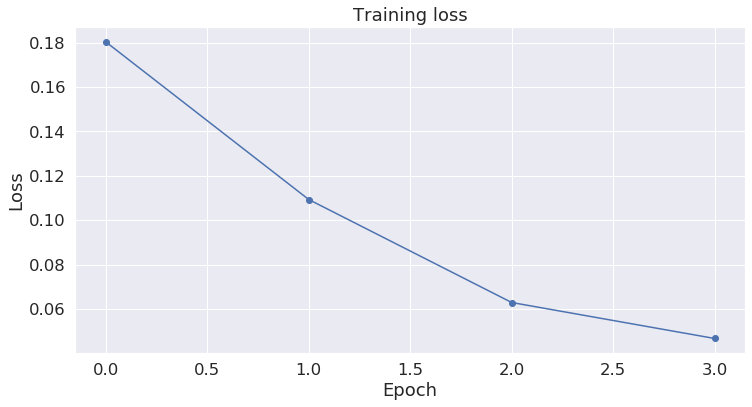

In [29]:
import matplotlib.pyplot as plt

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(loss_values, 'b-o')

# Label the plot.
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.show()

In [30]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(test_inputs)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
y_pred , y_true = [], []

# Predict 
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  y_pred.append(logits)
  y_true.append(label_ids)

print('    DONE.')

Predicting labels for 3,808 test sentences...
    DONE.


In [32]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(y_true)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(y_pred[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(y_true[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


/home/tdenimal/miniconda3/envs/nlp_clean/lib/python3.7/site-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


In [33]:
# Combine the predictions for each batch into a single list of 0s and 1s.
flat_predictions = [item for sublist in y_pred for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = [item for sublist in y_true for item in sublist]

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('MCC: %.3f' % mcc)

MCC: 0.883


In [34]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)


Saving model to ./model_save/


('./model_save/sentencepiece.bpe.model',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [180]:
!ls -l --block-size=K ./model_save/

total 435288K
-rw-r--r-- 1 tdenimal tdenimal      2K mars   2 01:18 config.json
-rw-r--r-- 1 tdenimal tdenimal 434481K mars   2 01:18 pytorch_model.bin
-rw-r--r-- 1 tdenimal tdenimal    792K mars   2 01:18 sentencepiece.bpe.model
-rw-r--r-- 1 tdenimal tdenimal      1K mars   2 01:18 special_tokens_map.json
-rw-r--r-- 1 tdenimal tdenimal      1K mars   2 01:18 tokenizer_config.json


In [103]:
# Load a trained model and vocabulary that you have fine-tuned
output_dir = './model_save/'
device = torch.device("cuda")

model = CamembertForSequenceClassification.from_pretrained(output_dir)
tokenizer = CamembertTokenizer.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

CamembertForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(32005, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm(torch.Size([768]), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm(torch.Size([768]

In [104]:
#classifier_fn – classifier prediction probability function, 
#which takes a list of d strings and outputs a (d, k) numpy array with prediction probabilities, 
#where k is the number of classes. For ScikitClassifiers , this is classifier.predict_proba.


def custom_predictor(texts):
    
    logits_l = []
    
    # Tokenize all of the sentences and map the tokens to thier word IDs.
    input_ids = []

    # For every sentence...
    for sent in texts:
        # `encode` will:
        #   (1) Tokenize the sentence.
        #   (2) Prepend the `[CLS]` token to the start.
        #   (3) Append the `[SEP]` token to the end.
        #   (4) Map tokens to their IDs.
    
        encoded_sent = tokenizer.encode(
                                sent,                      # Sentence to encode.
                                add_special_tokens = True, # Add '[CLS]' and '[SEP]'

                                # This function also supports truncation and conversion
                                # to pytorch tensors, but we need to do padding, so we
                                # can't use these features :( .
                                #max_length = 128,          # Truncate all sentences.
                                #return_tensors = 'pt',     # Return pytorch tensors.
                       )
    
        # Add the encoded sentence to the list.
        input_ids.append(encoded_sent)
        
    #Padd & truncate
    input_ids = truncate_n_padding(sequences=input_ids,max_len=512)
        
    # Create attention masks
    attention_masks = []

    # For each sentence...
    for sent in input_ids:
    
        # Create the attention mask.
        #   - If a token ID is 0, then it's padding, set the mask to 0.
        #   - If a token ID is > 0, then it's a real token, set the mask to 1.
        att_mask = [int(token_id > 0) for token_id in sent]
    
        # Store the attention mask for this sentence.
        attention_masks.append(att_mask)
        
    
    inputs_ = torch.tensor(input_ids,dtype=torch.int64)
    att_mask = torch.tensor(attention_masks,dtype=torch.int64)
    
    batch_size = 3

    # Create the DataLoader for our training set.
    data_ = TensorDataset(inputs_, att_mask)
    sampler_ = RandomSampler(data_)
    dataloader_ = DataLoader(data_, sampler=sampler_, batch_size=batch_size)
    
    
    # Put model in evaluation mode
    model.eval()

    # Tracking variables 
    y_preds = []
    
    # Predict 
    for batch in dataloader_:
  
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
  
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask = batch
    
    
        # Telling the model not to compute or store gradients, saving memory and 
        # speeding up prediction
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(b_input_ids, token_type_ids=None, 
                          attention_mask=b_input_mask)

        logits = output[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu()
        
        y_preds.append(logits)
        
    
    #Compute and return preds
    return np.concatenate([torch.nn.functional.softmax(y_pred, dim=1).numpy() for y_pred in y_preds])


In [123]:
custom_predictor(["mauvais fournisseur."])

array([[0.99799937, 0.00200062]], dtype=float32)

In [124]:
text = "Je n'aime pas ce fournisseur."
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names=['NEGATIF','POSITIF'])
exp = explainer.explain_instance(text, 
                                 custom_predictor,
                                 num_features=6,
                                 num_samples=5000)

In [125]:
exp.show_in_notebook()

In [111]:
exp.as_list()

[('n', 0.024667550699839495),
 ('pas', 0.021398498258493645),
 ('aime', -0.002397797255371158),
 ('Je', 0.00021432768577830114)]